In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Embedding, Dropout, LSTM, Input, Bidirectional, Concatenate, Conv1D, GlobalMaxPool1D, MaxPooling1D
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read clean dataset pre-processati
#read sets enhanced after analysis and cleaning
df_train = pd.read_pickle('/content/drive/MyDrive/train_a_clean.pkl')
df_dev = pd.read_pickle('/content/drive/MyDrive/dev_a_clean.pkl')
#
df_test = pd.read_pickle('/content/drive/MyDrive/test_a_clean.pkl')

#datasets con preprocessing con apostrofi
df_train_apo = pd.read_pickle('/content/drive/MyDrive/train_a_clean_apo.pkl')
df_dev_apo = pd.read_pickle('/content/drive/MyDrive/dev_a_clean_apo.pkl')
#
df_test_apo = pd.read_pickle('/content/drive/MyDrive/test_a_clean_apo.pkl')

**FEATURES EXTRACTION**

estrazione features tf-idf:



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#TF-IDF : le parole sono conteggiate per frequenza e poi calcolo  peso relativo (importanza della frequenza delle parole meno frequenti)
tfidf = TfidfVectorizer(max_features= 5000,stop_words=list(it_stop))

X_train_tfidf = tfidf.fit_transform(train_clean['text'])
X_dev_tfidf = tfidf.transform(dev_clean['text'])
print('Train size: ',X_train_tfidf.shape)
print('dev size: ',X_dev_tfidf.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gl', 'nient'] not in stop_words.
  warnings.warn(


Train size:  (13653, 5000)
dev size:  (552, 5000)


In [ ]:
#TF-IDF : le parole sono conteggiate per frequenza e poi calcolo  peso relativo (importanza della frequenza delle parole meno frequenti)
tfidf_apo = TfidfVectorizer(max_features= 10000,ngram_range=(1,3),stop_words=list(it_stop)) # features da prepocessing senza esclusione apostrofi

X_train_tfidf_apo = tfidf_apo.fit_transform(train_clean_apo['text'])
X_dev_tfidf_apo = tfidf_apo.transform(dev_clean_apo['text'])
print('Train size: ',X_train_tfidf_apo.shape)
print('dev size: ',X_dev_tfidf_apo.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gl', 'nient'] not in stop_words.
  warnings.warn(


Train size:  (13653, 10000)
dev size:  (552, 10000)


In [ ]:
tfidf_apo.get_feature_names_out()[2150:2160]

array(['coppia', 'coppia aperta', 'coprifuoco', 'cor', 'cor cazzo',
       'cor core', 'coraggio', 'corda', 'core', 'core location'],
      dtype=object)

ENCONDING LABELS

In [ ]:
from sklearn.preprocessing import LabelEncoder
# encoding labels to numerical
def encode_labels(y_train, y_dev, y_test):
 le = LabelEncoder()
 le.fit(y_train)
 y_train_enc = le.transform(y_train)
 y_dev_enc = le.transform(y_dev)
 y_test_enc = le.transform(y_test)
 return y_train_enc, y_dev_enc, y_test_enc

In [ ]:
y_train, y_dev, y_test = encode_labels(df_train['region'], df_dev['region'], df_test['region'])

**CHALLENGE BASELINE**
- **MOST FREQUENT BASELINE (MSB) FOR DEV SET**
- **LOGISTIC REGRESSION**(default scikit-learn hyperparameters)

| Baseline name          | Precision | Recall | Macro F1 |
|------------------------|-----------|--------|----------|
| Most frequent baseline | 0.0160    | 0.0769 | 0.0265   |
| Logistic regression    | 0.7686    | 0.5389 | 0.5872   |

**TF-IDF + NAIVE BAYES + CLASS WEIGHTS**

In [ ]:
from sklearn import naive_bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

use class weight for imbalance labels

In [ ]:
from sklearn.utils import compute_sample_weight
from sklearn.utils import compute_class_weight

In [ ]:
labels = np.unique(df_train['region'])
dev_labels = np.unique(df_dev['region'])

In [ ]:
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)
class_weights = compute_class_weight(class_weight= 'balanced', classes = np.unique(y_train), y = y_train)

In [ ]:
class_weights

array([ 4.52086093, 13.93163265,  2.42074468,  0.22581872,  2.13328125,
        3.10295455,  0.12185826,  3.06121076,  0.98648844,  3.77154696,
       19.50428571,  2.88037975,  2.56635338,  1.88577348,  1.10104839,
        1.62149644, 13.12788462,  5.01948529, 48.76071429,  0.89002608])

In [ ]:
dict_weights = dict(enumerate(class_weights))

In [ ]:
dict_weights

In [ ]:
#model tf-idf + NB
modelNB = MultinomialNB()
modelNB.fit(X_train_tfidf, y_train, sample_weights)#x train y train

MultinomialNB()

In [ ]:
predNB = modelNB.predict(X_dev_tfidf) #x dev
#evaluation
print(classification_report(y_dev, predNB, digits=4, target_names = labels)) # 7 regioni non vengono valutate

                       precision    recall  f1-score   support

              Abruzzo     0.0000    0.0000    0.0000         0
           Basilicata     0.0000    0.0000    0.0000         0
             Calabria     0.8000    0.4444    0.5714        27
             Campania     0.9136    0.8706    0.8916        85
       Emilia Romagna     0.6154    0.5333    0.5714        30
Friuli-Venezia Giulia     0.5500    0.4400    0.4889        25
                Lazio     0.8641    0.7739    0.8165       115
              Liguria     0.8333    0.8000    0.8163        25
            Lombardia     0.8788    0.6744    0.7632        43
               Marche     0.0000    0.0000    0.0000         0
               Molise     0.0000    0.0000    0.0000         0
             Piemonte     0.8571    0.7200    0.7826        25
               Puglia     0.6667    0.4444    0.5333        27
             Sardegna     0.9310    0.8710    0.9000        31
              Sicilia     0.8000    0.7000    0.7467  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

**NB BAYES UPDATE: TFIDF WITH STOP WORDS SPACY AND NGRAMS 1-3 + CLASS WEIGHTS**

In [ ]:
NB_2 = MultinomialNB()
NB_2.fit(X_train_tfidf_apo, y_train, sample_weights)#x train y train

MultinomialNB()

In [ ]:
pred_nb_2 = NB_2.predict(X_dev_tfidf_apo) #x dev
#evaluation
print(classification_report(y_dev, pred_nb_2, digits=4, target_names = labels)) # 7 regioni non vengono valutate

                       precision    recall  f1-score   support

              Abruzzo     0.0000    0.0000    0.0000         0
           Basilicata     0.0000    0.0000    0.0000         0
             Calabria     0.7778    0.5185    0.6222        27
             Campania     0.8904    0.7647    0.8228        85
       Emilia Romagna     0.6429    0.6000    0.6207        30
Friuli-Venezia Giulia     0.5789    0.4400    0.5000        25
                Lazio     0.9286    0.6783    0.7839       115
              Liguria     0.8500    0.6800    0.7556        25
            Lombardia     0.9032    0.6512    0.7568        43
               Marche     0.0000    0.0000    0.0000         0
               Molise     0.0000    0.0000    0.0000         0
             Piemonte     0.7391    0.6800    0.7083        25
               Puglia     0.7143    0.3704    0.4878        27
             Sardegna     0.8235    0.9032    0.8615        31
              Sicilia     0.7727    0.8500    0.8095  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**NEURAL NETWORK**

TOKENIZATION

In [ ]:
#tokenization prepocessing normale
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text']) #Aggiorna/crea il vocabolario interno sulla base di un elenco di testi

X_train = tokenizer.texts_to_sequences(df_train['text']) #converte le parole di ogni testo nel suo indice corrispondente del vocabolario; ritorna la matrice con gli array delle frasi con parole indicizzate
#print("X_train[0]",X_train[0])
X_dev = tokenizer.texts_to_sequences(df_dev['text'])
#print("X_dev[0]",X_dev[0])
vocab_size = len(tokenizer.word_index) + 1 #adding 1 because of reserverd 0 index
print("vocabulary size: ", vocab_size)

maxlen_train = max( len(x) for x in X_train)
maxlen_dev = max( len(x) for x in X_dev)

print("maxlen train dataset: ", maxlen_train)
print("maxlen dev dataset: ", maxlen_dev)

#padding
maxlen = maxlen_train

X_train = pad_sequences(X_train, padding= "post", maxlen = maxlen)
X_dev = pad_sequences(X_dev, padding ="post" , maxlen = maxlen)
print("After Padding ...")
print("X_train shape:", X_train.shape)
print("X_dev shape:", X_dev.shape)

vocabulary size:  33014
maxlen train dataset:  38
maxlen dev dataset:  25
After Padding ...
X_train shape: (13653, 38)
X_dev shape: (552, 38)


In [ ]:
X_train[111]

array([  15, 3707,    1,   48,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [ ]:
tokenizer.texts_to_sequences('nient')

[[7], [3], [], [7], [15]]

In [ ]:
#tokenization del prepocessing con apostrofi
tokenizer_apo = Tokenizer()
tokenizer_apo.fit_on_texts(df_train_apo['text']) #Aggiorna/crea il vocabolario interno sulla base di un elenco di testi

X_train_apo = tokenizer_apo.texts_to_sequences(df_train_apo['text']) #converte le parole di ogni testo nel suo indice corrispondente del vocabolario; ritorna la matrice con gli array delle frasi con parole indicizzate
#print("X_train_apo[0]",X_train_apo[0])
X_dev_apo = tokenizer_apo.texts_to_sequences(df_dev_apo['text'])
#print("X_dev_apo[0]",X_dev_apo[0])

vocab_size_apo = len(tokenizer_apo.word_index) + 1 #adding 1 because of reserverd 0 index
print("vocabulary size con apostrofi: ", vocab_size_apo)

maxlen_train_apo = max( len(x) for x in X_train_apo)
maxlen_dev_apo = max( len(x) for x in X_dev_apo)

print("maxlen train dataset con apostrofi: ", maxlen_train_apo)
print("maxlen dev dataset con apostrofi: ", maxlen_dev_apo)

#padding
maxlen_apo = maxlen_train_apo

X_train_apo = pad_sequences(X_train_apo, padding= "post", maxlen = maxlen_apo)
X_dev_apo = pad_sequences(X_dev_apo, padding ="post" , maxlen = maxlen_apo)
print("After Padding ...")
print("X_train shape con apostrofi:", X_train_apo.shape)
print("X_dev shape con apostrofi:", X_dev_apo.shape)

vocabulary size con apostrofi:  36908
maxlen train dataset con apostrofi:  39
maxlen dev dataset con apostrofi:  25
After Padding ...
X_train shape con apostrofi: (13653, 39)
X_dev shape con apostrofi: (552, 39)


EMBEDDING FOR INPUT LAYER

word_input=Input(shape=(maxlen,),dtype='float64')
Embedding(input_dim=vocab_size,output_dim=8,input_length=maxlen)

PARAMETERS OF THE EMBEDDING LAYER ---

'input_dim' = the vocab size that we will choose. In other words it is the number of unique words in the vocab.

'output_dim' = the number of dimensions we wish to embed into. Each word will be represented by a vector of this much dimensions.

'input_length' = lenght of the maximum document. which is stored in maxlen variable in our case.

In [ ]:
# encoding labels
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train, dtype='uint8')
y_dev_cat = to_categorical(y_dev, dtype='uint8')
y_test_cat = to_categorical(y_test, dtype='uint8')
print(y_dev_cat.shape)
print(y_dev_cat)

(552, 20)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


In [ ]:
del model, history#, y_pred_, accuracy

# **MODELLI**

In [ ]:
import keras
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
stop_callbacks_list = [early_stop]

LSTM BASE - PRIMO MODELLO

In [ ]:
embedding_dim = 200


lstm_1 = Sequential()

lstm_1.add(Embedding(
    vocab_size,
    output_dim = embedding_dim,
    input_length = maxlen)) #output 3d (batch_size, input_length, output_dim) ->

#we have to go to 1D
#model.add(Flatten())
lstm_1.add(LSTM(128, recurrent_dropout=0.2, return_sequences=True))
lstm_1.add(layers.Flatten())
lstm_1.add(Dense(64, activation = "relu"))
lstm_1.add(Dense(20, activation = "softmax"))

#end of model architecture

lstm_1.compile(optimizer = "adam", loss ="categorical_crossentropy", metrics = ['accuracy'],)

lstm_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 38, 200)           6602800   
                                                                 
 lstm_2 (LSTM)               (None, 38, 128)           168448    
                                                                 
 flatten_2 (Flatten)         (None, 4864)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                311360    
                                                                 
 dense_5 (Dense)             (None, 20)                1300      
                                                                 
Total params: 7,083,908
Trainable params: 7,083,908
Non-trainable params: 0
_________________________________________________________________


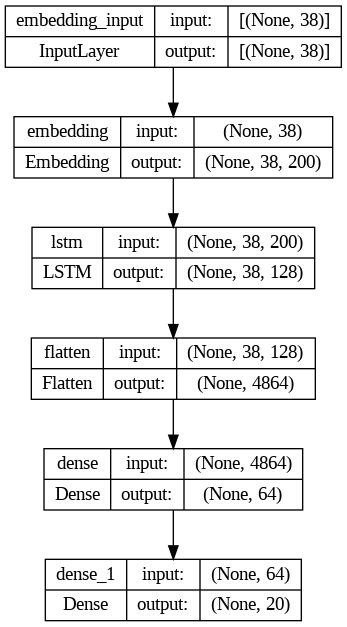

In [ ]:
# Plot model graph
tf.keras.utils.plot_model(lstm_1,
                          to_file='lstm_1.png',
                          show_shapes=True
                          )
#Image(retina=True, filename='lstm_1.png')

In [ ]:
history_lstm1 = lstm_1.fit(np.array(X_train), np.array(y_train_cat), epochs=10,
                    validation_data=(np.array(X_dev), np.array(y_dev_cat)),
                    batch_size=32,
                    callbacks=[stop_callbacks_list]
                    )

Epoch 1/10
427/427 [==============================] - 109s 235ms/step - loss: 1.4866 - accuracy: 0.5981 - val_loss: 1.4398 - val_accuracy: 0.5435
Epoch 2/10
427/427 [==============================] - 95s 224ms/step - loss: 0.8049 - accuracy: 0.7760 - val_loss: 1.0746 - val_accuracy: 0.6975
Epoch 3/10
427/427 [==============================] - 97s 226ms/step - loss: 0.3975 - accuracy: 0.8861 - val_loss: 1.3069 - val_accuracy: 0.6812
Epoch 4/10
427/427 [==============================] - 98s 230ms/step - loss: 0.2117 - accuracy: 0.9395 - val_loss: 1.3747 - val_accuracy: 0.6938
Epoch 5/10
427/427 [==============================] - 95s 223ms/step - loss: 0.1172 - accuracy: 0.9686 - val_loss: 1.8346 - val_accuracy: 0.6268


EVALUATION

In [ ]:
def evaluation(model, X, y):
    print(f"Prediction labels on sample ...")
    pred = model.predict(X)
    pred = np.argmax(pred, axis=1)
    print(f"Evaluation in course ... ")
    print(f"Classification Report & Confusion Matrix ... ")
    print(classification_report(y, pred))
    print("\n")
    cm = confusion_matrix(y, pred)
    plot_confusion_matrix(conf_mat=cm, figsize=(8,8))

In [ ]:
evaluation(lstm_1, X_dev, y_dev)

Prediction labels on sample ...
18/18 [==============================] - 1s 28ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.57      0.44      0.50        27
           3       0.82      0.82      0.82        85
           4       0.67      0.47      0.55        30
           5       0.38      0.12      0.18        25
           6       0.70      0.89      0.78       115
           7       1.00      0.48      0.65        25
           8       0.35      0.65      0.46        43
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.93      0.52      0.67        25
          12       0.80      0.44      0.57        27
          13       0.79      0.61      0.69        31
          14       0.52      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

In [ ]:
#plotting evaluation
def plot_history(history):
    acc = history.history['accuracy']
    dev_acc = history.history['val_accuracy']
    loss = history.history['loss']
    dev_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, dev_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, dev_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
plot_history(history)

**LSTM UPGRADE : LSTM + 2 DENSE LAYER + OUTPUT**

MODELLO APPLICATO SIA A PRE-PROCESSING NORMALE CHE A QUELLO CON APOSTROFI INCLUSI

In [ ]:
def LSTM_2(max_features, embedding_dims, maxlen, class_num=20, last_activation="softmax"):

  model = Sequential() # (?, ...)

  model.add(Embedding(max_features, embedding_dims, input_length=maxlen)) #(batch_size, maxlen, output_dim) -> (?, ... , ...))

  model.add(Bidirectional(LSTM(128, return_sequences=True)))
  model.add(layers.Flatten())
  model.add(Dense(128, activation = "relu"))
  model.add(keras.layers.Dropout(0.3))
  model.add(Dense(64, activation = "relu"))
  model.add(keras.layers.Dropout(0.3))

  model.add(Dense(class_num, activation=last_activation)) # (? , ...) output layer

  model.compile(optimizer = "adam", loss ="categorical_crossentropy", metrics = ["accuracy"])
  model.summary()

  return model

In [ ]:
#modello con preprocessing totale
model_2 = LSTM_2(vocab_size, 200, maxlen) #up the embedding dimension

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 38, 200)           6602800   
                                                                 
 bidirectional (Bidirectiona  (None, 38, 256)          336896    
 l)                                                              
                                                                 
 flatten_3 (Flatten)         (None, 9728)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1245312   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                      

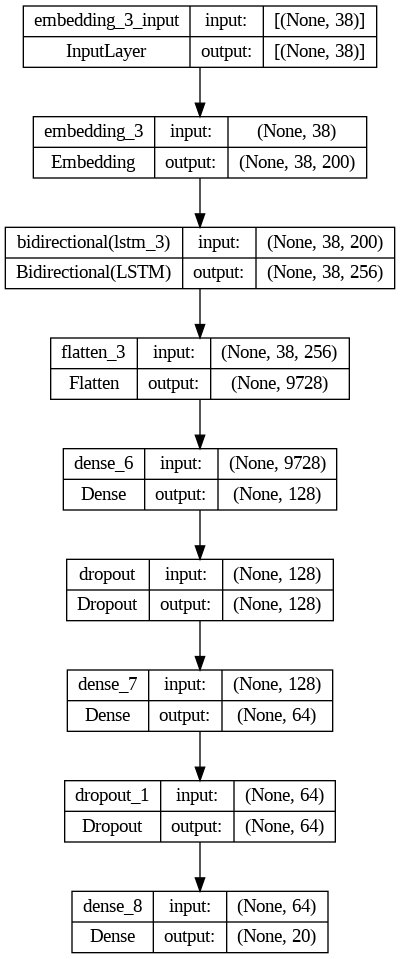

In [ ]:
tf.keras.utils.plot_model(model_2,to_file='lstm_2.png',show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="best_weights.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             patience=3,
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]

In [ ]:
history_lstm_2 = model_2.fit(np.array(X_train), np.array(y_train_cat), epochs=10,
                    validation_data=(np.array(X_dev), np.array(y_dev_cat)),
                    batch_size=32,
                    callbacks=[stop_callbacks_list])

Epoch 1/10
427/427 [==============================] - 127s 283ms/step - loss: 1.6131 - accuracy: 0.5810 - val_loss: 1.7149 - val_accuracy: 0.4529
Epoch 2/10
427/427 [==============================] - 120s 281ms/step - loss: 1.0294 - accuracy: 0.7205 - val_loss: 1.3132 - val_accuracy: 0.5851
Epoch 3/10
427/427 [==============================] - 121s 283ms/step - loss: 0.6831 - accuracy: 0.7995 - val_loss: 1.3616 - val_accuracy: 0.6775
Epoch 4/10
427/427 [==============================] - 120s 280ms/step - loss: 0.4571 - accuracy: 0.8640 - val_loss: 1.3408 - val_accuracy: 0.6884
Epoch 5/10
427/427 [==============================] - 133s 311ms/step - loss: 0.3056 - accuracy: 0.9099 - val_loss: 1.3979 - val_accuracy: 0.6812


Prediction labels on sample ...
18/18 [==============================] - 2s 47ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.50      0.44      0.47        27
           3       0.83      0.89      0.86        85
           4       0.57      0.43      0.49        30
           5       0.43      0.40      0.42        25
           6       0.77      0.90      0.83       115
           7       1.00      0.40      0.57        25
           8       0.65      0.70      0.67        43
           9       0.00      0.00      0.00         0
          11       0.45      0.76      0.57        25
          12       0.91      0.37      0.53        27
          13       0.85      0.74      0.79        31
          14       0.59      0.72      0.65        40
          15       0.68      0.56      0.61        34
          19       0.72      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

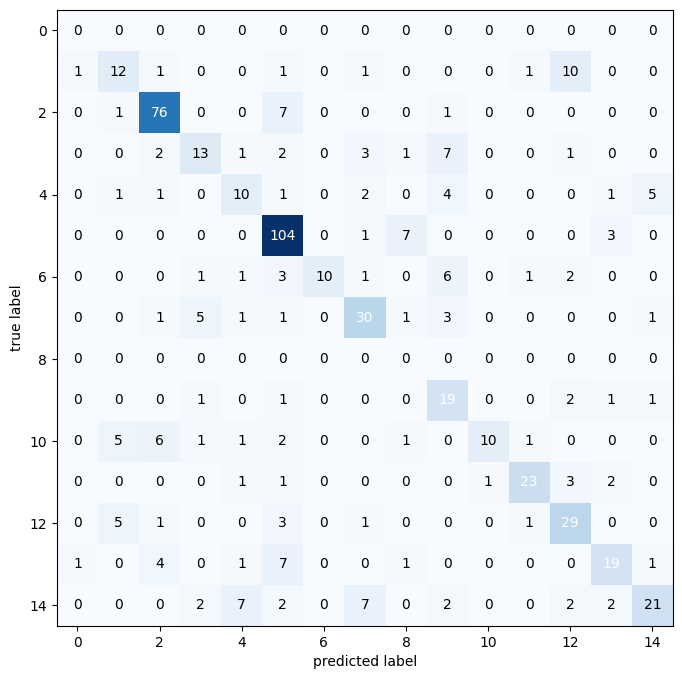

In [ ]:
evaluation(model_2, X_dev, y_dev)

In [ ]:
#eval on test set
X_test = tokenizer.texts_to_sequences(df_test['text'])
#print("X_dev_apo[0]",X_dev_apo[0])

X_test = pad_sequences(X_test, padding ="post" , maxlen = maxlen)
print("After Padding ...")
print("X_test shape con apostrofi:", X_test.shape)

After Padding ...
X_test shape con apostrofi: (818, 38)


In [ ]:
#eval on test set
X_test_apo = tokenizer_apo.texts_to_sequences(df_test_apo['text'])
#print("X_dev_apo[0]",X_dev_apo[0])

X_test_apo = pad_sequences(X_test_apo, padding ="post" , maxlen = maxlen_apo)
print("After Padding ...")
print("X_test shape con apostrofi:", X_test_apo.shape)

After Padding ...
X_test shape con apostrofi: (818, 39)


Prediction labels on sample ...
26/26 [==============================] - 1s 47ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           2       0.41      0.56      0.47        27
           3       0.86      0.92      0.89       128
           4       0.56      0.40      0.47        45
           5       0.48      0.44      0.46        25
           6       0.74      0.92      0.82       173
           7       0.84      0.64      0.73        25
           8       0.56      0.61      0.58        64
           9       0.11      0.12      0.11        16
          11       0.37      0.80      0.51        25
          12       0.44      0.15      0.22        27
          13       0.94      0.66      0.78        47
          14       0.69      0.77      0.72        60
          15       0.63      0.57      0.60        51
          16       0.00      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


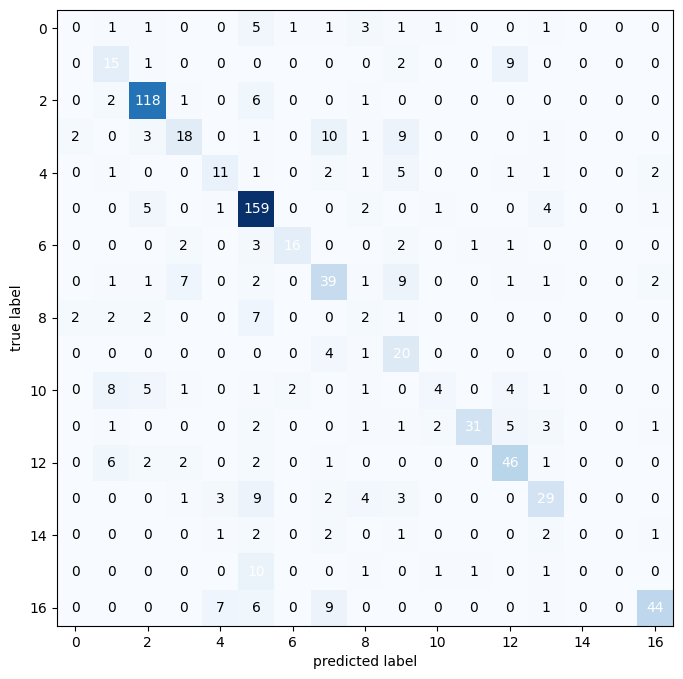

In [ ]:
evaluation(model_2, X_test, y_test)

modello lstm_2 con preprocessing con apostrofi

In [ ]:
#modello con preprocessing con uso di apostrofi e parole con apostrofi
model_2_apo = LSTM_2(vocab_size_apo, 200, maxlen_apo)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 39, 200)           7382600   
                                                                 
 bidirectional (Bidirectiona  (None, 39, 256)          336896    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 9984)              0         
                                                                 
 dense (Dense)               (None, 128)               1278080   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [ ]:
filepath="best_weights_apo.h5"
checkpoint_apo = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             patience=3,
                             save_best_only=True,
                             mode='min')
callbacks_list_apo = [checkpoint_apo]

In [ ]:
history_2_apo = model_2_apo.fit(np.array(X_train_apo), np.array(y_train_cat), epochs=10,
                    validation_data=(np.array(X_dev_apo), np.array(y_dev_cat)),
                    batch_size=32,
                    callbacks=stop_callbacks_list)

Epoch 1/10
427/427 [==============================] - 185s 407ms/step - loss: 1.6071 - accuracy: 0.5661 - val_loss: 1.6012 - val_accuracy: 0.4909
Epoch 2/10
427/427 [==============================] - 128s 299ms/step - loss: 0.9692 - accuracy: 0.7332 - val_loss: 1.2794 - val_accuracy: 0.6087
Epoch 3/10
427/427 [==============================] - 127s 296ms/step - loss: 0.5950 - accuracy: 0.8261 - val_loss: 1.2281 - val_accuracy: 0.6594
Epoch 4/10
427/427 [==============================] - 123s 289ms/step - loss: 0.3524 - accuracy: 0.8966 - val_loss: 1.3994 - val_accuracy: 0.6739
Epoch 5/10
427/427 [==============================] - 128s 301ms/step - loss: 0.2074 - accuracy: 0.9382 - val_loss: 1.6827 - val_accuracy: 0.6703
Epoch 6/10
427/427 [==============================] - 122s 286ms/step - loss: 0.1408 - accuracy: 0.9595 - val_loss: 1.6730 - val_accuracy: 0.6685


Prediction labels on sample ...
18/18 [==============================] - 2s 47ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.40      0.37      0.38        27
           3       0.83      0.82      0.83        85
           4       0.48      0.37      0.42        30
           5       0.73      0.32      0.44        25
           6       0.74      0.90      0.81       115
           7       1.00      0.40      0.57        25
           8       0.57      0.56      0.56        43
           9       0.00      0.00      0.00         0
          11       0.67      0.64      0.65        25
          12       0.63      0.44      0.52        27
          13       0.96      0.77      0.86        31
          14       0.69      0.72      0.71        40
          15       0.54      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

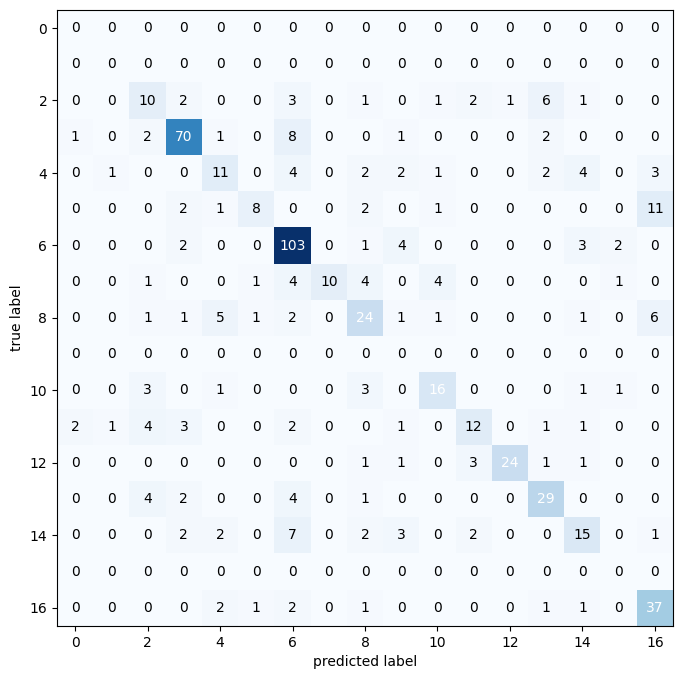

In [ ]:
evaluation(model_2_apo, X_dev_apo, y_dev_apo) # eval on val set

Prediction labels on sample ...
26/26 [==============================] - 1s 46ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.36      0.27      0.31        15
           1       0.00      0.00      0.00         0
           2       0.51      0.78      0.62        27
           3       0.83      0.83      0.83       128
           4       0.34      0.27      0.30        45
           5       0.37      0.28      0.32        25
           6       0.72      0.91      0.80       173
           7       0.80      0.32      0.46        25
           8       0.56      0.64      0.60        64
           9       0.00      0.00      0.00        16
          11       0.65      0.60      0.63        25
          12       0.39      0.26      0.31        27
          13       1.00      0.72      0.84        47
          14       0.78      0.75      0.76        60
          15       0.60      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

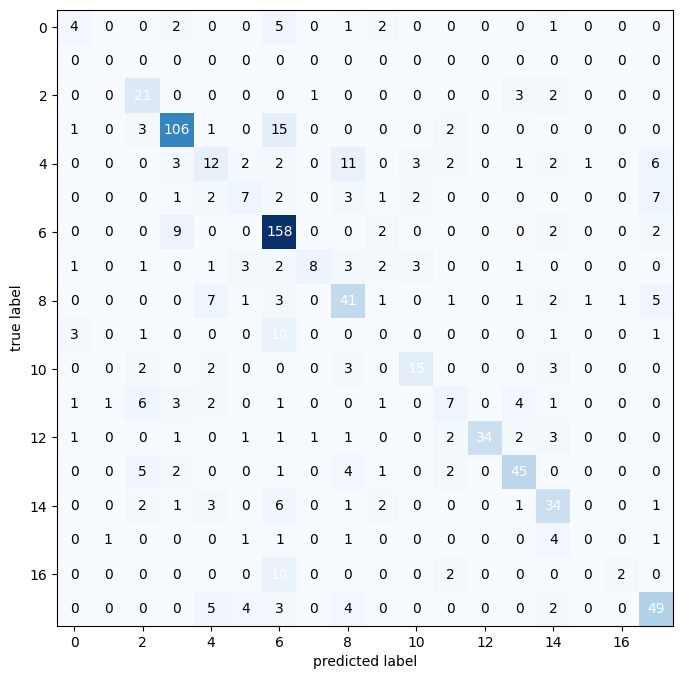

In [ ]:
evaluation(model_2_apo, X_test_apo, y_test_apo)

cross validation modello 2 LSTM

In [ ]:
# Merge inputs and targets
inputs = np.concatenate((X_train_apo, X_dev_apo), axis=0)
targets = np.concatenate((y_train_apo, y_dev_apo), axis=0)

In [ ]:
from sklearn.model_selection import KFold
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

cvscores = []
n_fold = 1

for train, test in kfold.split(inputs, targets):

  cross_model_2_apo = LSTM_2(vocab_size_apo, 300, maxlen_apo)
  targets_cat = to_categorical(targets, dtype='uint8')
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {n_fold} ...')
  history_2_cross = cross_model_2_apo.fit(np.array(inputs[train]), np.array(targets_cat[train]), epochs=5,
                                          #validation_data=(np.array(X_dev_apo), np.array(y_dev_apo_cat)),
                                          batch_size=32,
                                          #callbacks=stop_callbacks_list)
                                          )
  print(f"Prediction labels on sample ...")
  prediction = cross_model_2_apo.predict(inputs[test])
  prediction = np.argmax(prediction, axis=1)
  print(f"Evaluation in course ... ")
  score = f1_score(targets[test], prediction , average="macro")
  print(f'f1 macro score for fold {n_fold}: {score}')
  cvscores.append(score)
  n_fold = n_fold + 1

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 39, 300)           11073900  
                                                                 
 bidirectional_2 (Bidirectio  (None, 39, 256)          439296    
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 9984)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1278080   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                      

In [ ]:
print('------------------------------------------------------------------------')
print(f'F1 score avg:')
print(np.mean(cvscores))

------------------------------------------------------------------------
F1 score avg:
0.3717955630702391


## **CNN**

In [ ]:
def CNN_1(max_features, embedding_dims, conv_dim, maxlen, class_num=20, last_activation="softmax"):

  model = Sequential() # (?, ...)

  model.add(Embedding(max_features, embedding_dims, input_length=maxlen)) #(batch_size, maxlen, output_dim) -> (?, ... , ...))

  model.add(Conv1D(conv_dim, 3, activation='relu'))
  model.add(GlobalMaxPool1D())

  model.add(Dense(128, activation = "relu"))
  model.add(keras.layers.Dropout(0.3))

  model.add(Dense(class_num, activation=last_activation)) # (? , ...) output layer

  model.compile(optimizer = "adam", loss ="categorical_crossentropy", metrics = ["accuracy"])
  model.summary()

  return model

In [ ]:
model_cnn = CNN_1(vocab_size, 200, 512, maxlen)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 38, 200)           6603800   
                                                                 
 conv1d_9 (Conv1D)           (None, 36, 512)           307712    
                                                                 
 global_max_pooling1d_4 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 20)                2580      
                                                      

In [ ]:
history_cnn = model_cnn.fit(np.array(X_train), np.array(y_train_cat), epochs=10,
                    validation_data=(np.array(X_dev), np.array(y_dev_cat)),
                    batch_size=32,
                    callbacks=[stop_callbacks_list])

Epoch 1/10
427/427 [==============================] - 79s 181ms/step - loss: 1.5233 - accuracy: 0.5999 - val_loss: 1.4339 - val_accuracy: 0.5833
Epoch 2/10
427/427 [==============================] - 77s 179ms/step - loss: 0.8536 - accuracy: 0.7723 - val_loss: 0.9708 - val_accuracy: 0.7210
Epoch 3/10
427/427 [==============================] - 77s 180ms/step - loss: 0.4268 - accuracy: 0.8811 - val_loss: 1.0869 - val_accuracy: 0.7283
Epoch 4/10
427/427 [==============================] - 75s 175ms/step - loss: 0.1934 - accuracy: 0.9448 - val_loss: 1.2781 - val_accuracy: 0.7283
Epoch 5/10
427/427 [==============================] - 75s 176ms/step - loss: 0.0969 - accuracy: 0.9740 - val_loss: 1.4399 - val_accuracy: 0.7283


Prediction labels on sample ...
18/18 [==============================] - 0s 15ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.55      0.41      0.47        27
           3       0.84      0.93      0.88        85
           4       0.74      0.57      0.64        30
           5       0.60      0.24      0.34        25
           6       0.78      0.93      0.85       115
           7       0.81      0.68      0.74        25
           8       0.58      0.74      0.65        43
           9       0.00      0.00      0.00         0
          11       0.94      0.68      0.79        25
          12       0.83      0.37      0.51        27
          13       0.87      0.84      0.85        31
          14       0.67      0.80      0.73        40
          15       0.77      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

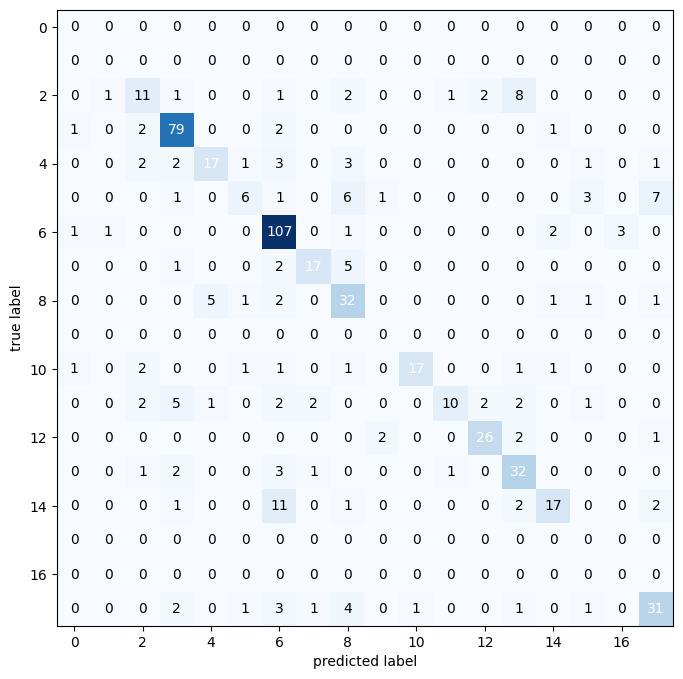

In [ ]:
evaluation(model_cnn, X_dev, y_dev)

Prediction labels on sample ...
26/26 [==============================] - 0s 14ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.10      0.07      0.08        15
           2       0.58      0.67      0.62        27
           3       0.80      0.89      0.84       128
           4       0.70      0.42      0.53        45
           5       0.38      0.24      0.29        25
           6       0.74      0.92      0.82       173
           7       0.70      0.56      0.62        25
           8       0.62      0.80      0.70        64
           9       0.00      0.00      0.00        16
          10       0.00      0.00      0.00         0
          11       0.95      0.76      0.84        25
          12       0.91      0.37      0.53        27
          13       0.89      0.85      0.87        47
          14       0.81      0.83      0.82        60
          15       0.70      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

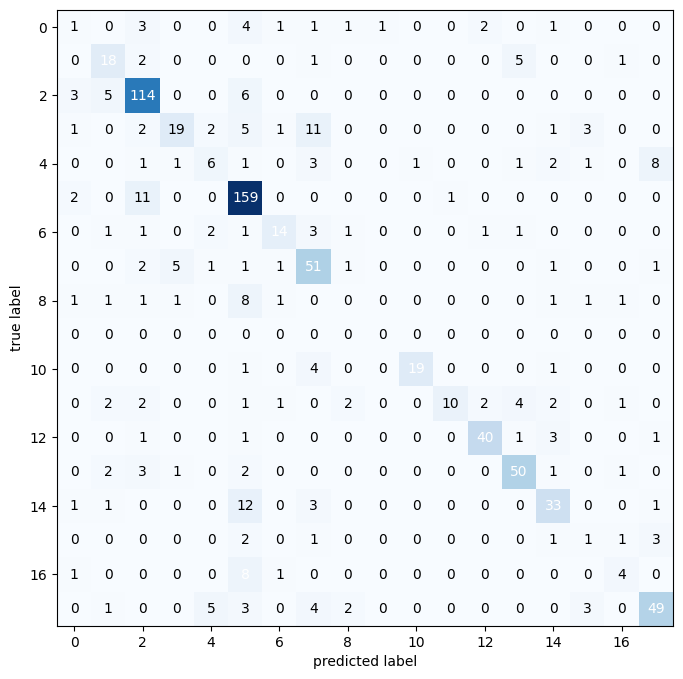

In [ ]:
evaluation(model_cnn, X_test, y_test)

cnn con preprocessing con apostrofi

In [ ]:
model_cnn_apo = CNN_1(vocab_size_apo, 200, 512, maxlen_apo)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 39, 200)           7382600   
                                                                 
 conv1d_11 (Conv1D)          (None, 37, 512)           307712    
                                                                 
 global_max_pooling1d_6 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_15 (Dense)            (None, 128)               65664     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 20)                2580      
                                                     

In [ ]:
history_cnn_apo = model_cnn_apo.fit(np.array(X_train_apo), np.array(y_train_cat), epochs=10,
                    validation_data=(np.array(X_dev_apo), np.array(y_dev_cat)),
                    batch_size=32,
                    callbacks=stop_callbacks_list)

Epoch 1/10
427/427 [==============================] - 93s 215ms/step - loss: 1.5601 - accuracy: 0.5893 - val_loss: 1.4840 - val_accuracy: 0.5254
Epoch 2/10
427/427 [==============================] - 80s 186ms/step - loss: 0.8766 - accuracy: 0.7643 - val_loss: 1.0910 - val_accuracy: 0.6830
Epoch 3/10
427/427 [==============================] - 82s 192ms/step - loss: 0.4369 - accuracy: 0.8751 - val_loss: 1.1833 - val_accuracy: 0.6975
Epoch 4/10
427/427 [==============================] - 85s 199ms/step - loss: 0.2020 - accuracy: 0.9423 - val_loss: 1.3198 - val_accuracy: 0.7065
Epoch 5/10
427/427 [==============================] - 79s 185ms/step - loss: 0.0964 - accuracy: 0.9730 - val_loss: 1.6295 - val_accuracy: 0.7174


Prediction labels on sample ...
18/18 [==============================] - 0s 15ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.75      0.44      0.56        27
           3       0.85      0.88      0.87        85
           4       0.58      0.50      0.54        30
           5       0.35      0.24      0.29        25
           6       0.76      0.94      0.84       115
           7       1.00      0.56      0.72        25
           8       0.74      0.67      0.71        43
           9       0.00      0.00      0.00         0
          11       0.76      0.64      0.70        25
          12       0.81      0.48      0.60        27
          13       0.82      0.74      0.78        31
          14       0.57      0.78      0.66        40
          15       0.96      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

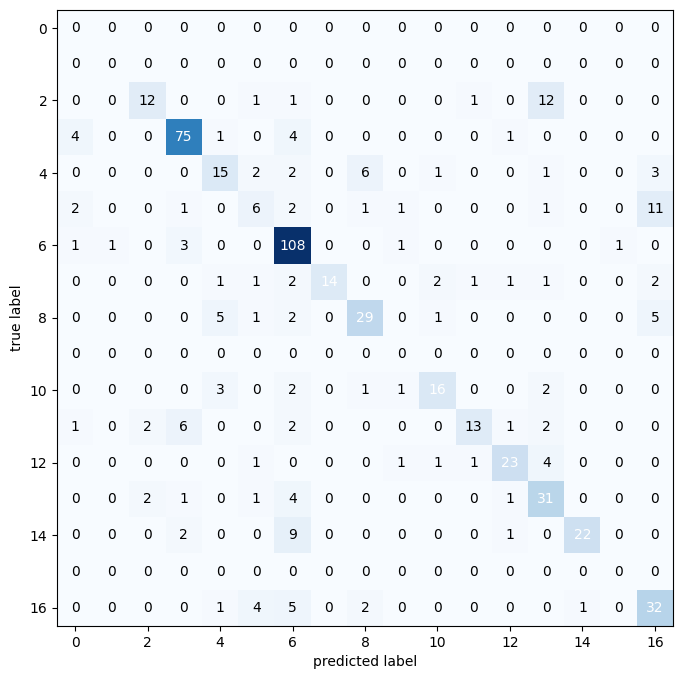

In [ ]:
evaluation(model_cnn_apo, X_dev_apo, y_dev)

In [ ]:
evaluation(model_cnn_apo, X_test_apo, y_test_apo)

Prediction labels on sample ...
26/26 [==============================] - 1s 26ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.12      0.13      0.13        15
           2       0.56      0.70      0.62        27
           3       0.79      0.90      0.84       128
           4       0.58      0.47      0.52        45
           5       0.43      0.40      0.42        25
           6       0.70      0.89      0.79       173
           7       0.93      0.52      0.67        25
           8       0.62      0.62      0.62        64
           9       0.17      0.06      0.09        16
          11       0.72      0.72      0.72        25
          12       0.59      0.37      0.45        27
          13       0.92      0.77      0.84        47
          14       0.75      0.80      0.77        60
          15       0.68      0.55      0.61        51
          16       0.25      0.

  **MODEL CNN DEEP**

In [ ]:
def CNN_2(max_features, embedding_dims, maxlen, class_num=20, last_activation="softmax"):

  model = Sequential() # (?, ...)

  model.add(Embedding(max_features, embedding_dims, input_length=maxlen)) #(batch_size, maxlen, output_dim) -> (?, ... , ...))

  model.add(Conv1D(512, 3, activation='relu',padding='same'))
  model.add(MaxPooling1D())
  model.add(Conv1D(512, 3, activation='relu',padding='same'))
  model.add(MaxPooling1D())
  model.add(Flatten())

  model.add(Dense(128, activation = "relu"))
  model.add(keras.layers.Dropout(0.4))
  model.add(Dense(64, activation = "relu"))
  model.add(keras.layers.Dropout(0.3))

  model.add(Dense(class_num, activation=last_activation)) # (? , ...) output layer

  model.compile(optimizer = "adam", loss ="categorical_crossentropy", metrics = ["accuracy"])
  model.summary()

  return model

In [ ]:
cnn_2 = CNN_2(vocab_size_apo, 200, maxlen_apo)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 39, 200)           7382600   
                                                                 
 conv1d_25 (Conv1D)          (None, 39, 512)           307712    
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 19, 512)          0         
 1D)                                                             
                                                                 
 conv1d_26 (Conv1D)          (None, 19, 512)           786944    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 9, 512)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4608)            

In [ ]:
del history_cnn_2 , cnn_2

In [ ]:
history_cnn_2 = cnn_2.fit(np.array(X_train_apo), np.array(y_train_cat), epochs=10,
                    validation_data=(np.array(X_dev_apo), np.array(y_dev_cat)),
                    batch_size=32,
                    callbacks=[stop_callbacks_list])

Epoch 1/10
427/427 [==============================] - 87s 201ms/step - loss: 1.7640 - accuracy: 0.5089 - val_loss: 1.8305 - val_accuracy: 0.4257
Epoch 2/10
427/427 [==============================] - 84s 197ms/step - loss: 1.2134 - accuracy: 0.6451 - val_loss: 1.7591 - val_accuracy: 0.4312
Epoch 3/10
427/427 [==============================] - 82s 193ms/step - loss: 0.9510 - accuracy: 0.6991 - val_loss: 1.6131 - val_accuracy: 0.5018
Epoch 4/10
427/427 [==============================] - 83s 194ms/step - loss: 0.7521 - accuracy: 0.7618 - val_loss: 1.4406 - val_accuracy: 0.6033
Epoch 5/10
427/427 [==============================] - 83s 194ms/step - loss: 0.5964 - accuracy: 0.8099 - val_loss: 1.3957 - val_accuracy: 0.6105
Epoch 6/10
427/427 [==============================] - 84s 196ms/step - loss: 0.4662 - accuracy: 0.8556 - val_loss: 1.4690 - val_accuracy: 0.6178
Epoch 7/10
427/427 [==============================] - 84s 196ms/step - loss: 0.3561 - accuracy: 0.8883 - val_loss: 1.6390 - val_ac

In [ ]:
evaluation(cnn_2, X_dev_apo, y_dev)

Prediction labels on sample ...
18/18 [==============================] - 0s 11ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.72      0.48      0.58        27
           3       0.85      0.86      0.85        85
           4       0.25      0.50      0.33        30
           5       0.17      0.08      0.11        25
           6       0.80      0.95      0.87       115
           7       0.57      0.32      0.41        25
           8       0.61      0.65      0.63        43
           9       0.00      0.00      0.00         0
          11       0.00      0.00      0.00        25
          12       0.43      0.44      0.44        27
          13       0.93      0.81      0.86        31
          14       0.59      0.65      0.62        40
          15       0.71      0.50      0.59        34
          19       0.71      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

  **MODEL CNN WITH 3 FILTERS**

In [ ]:
def CNN_deep(max_features, embedding_dims, conv_dim, maxlen, class_num=20, last_activation="softmax"):

  sequence_input = Input(shape=(maxlen,))

  embedding_layer = Embedding(max_features, embedding_dims, input_length=maxlen) #(batch_size, maxlen, output_dim) -> (?, ... , ...))

  embedded_sequences = embedding_layer(sequence_input)

  convs = []
  filter_sizes = [3,4,5]

  for fsz in filter_sizes:
    x = Conv1D(conv_dim, fsz, activation='relu',padding='same')(embedded_sequences)
    x = MaxPooling1D()(x)
    convs.append(x)

  x = Concatenate(axis=-1)(convs)
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  #x = Dense(64, activation='relu')(x)
  #x = Dropout(0.3)(x)
  output = Dense(class_num, activation = last_activation)(x)

  model = Model(sequence_input, output)

  model.compile(optimizer = "adam", loss ="categorical_crossentropy", metrics = ["accuracy"])
  model.summary()

  return model

In [ ]:
cnn_deep = CNN_deep(vocab_size, 200, 256, maxlen)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 embedding_21 (Embedding)       (None, 38, 200)      6603800     ['input_6[0][0]']                
                                                                                                  
 conv1d_31 (Conv1D)             (None, 38, 256)      153856      ['embedding_21[0][0]']           
                                                                                                  
 conv1d_32 (Conv1D)             (None, 38, 256)      205056      ['embedding_21[0][0]']           
                                                                                            

In [ ]:
tf.keras.utils.plot_model(cnn_deep,to_file='cnn_deep.png',show_shapes=True)

In [ ]:
#training and evaluation with preprocessing standard
history_cnn_deep = cnn_deep.fit(np.array(X_train), np.array(y_train_cat), epochs=10,
                    validation_data=(np.array(X_dev), np.array(y_dev_cat)),
                    batch_size=32,
                    callbacks=[stop_callbacks_list])

Epoch 1/10
427/427 [==============================] - 121s 279ms/step - loss: 1.5747 - accuracy: 0.5813 - val_loss: 1.6453 - val_accuracy: 0.4837
Epoch 2/10
427/427 [==============================] - 116s 273ms/step - loss: 0.9545 - accuracy: 0.7312 - val_loss: 1.2826 - val_accuracy: 0.5996
Epoch 3/10
427/427 [==============================] - 114s 266ms/step - loss: 0.5830 - accuracy: 0.8241 - val_loss: 1.2617 - val_accuracy: 0.6775
Epoch 4/10
427/427 [==============================] - 115s 269ms/step - loss: 0.3401 - accuracy: 0.8954 - val_loss: 1.4110 - val_accuracy: 0.7029
Epoch 5/10
427/427 [==============================] - 112s 261ms/step - loss: 0.2114 - accuracy: 0.9370 - val_loss: 1.4724 - val_accuracy: 0.6884
Epoch 6/10
427/427 [==============================] - 114s 268ms/step - loss: 0.1285 - accuracy: 0.9626 - val_loss: 1.9142 - val_accuracy: 0.6938


Prediction labels on sample ...
18/18 [==============================] - 1s 30ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.50      0.41      0.45        27
           3       0.85      0.85      0.85        85
           4       0.68      0.43      0.53        30
           5       0.73      0.32      0.44        25
           6       0.75      0.98      0.85       115
           7       1.00      0.48      0.65        25
           8       0.52      0.74      0.61        43
           9       0.00      0.00      0.00         0
          11       0.88      0.56      0.68        25
          12       0.52      0.41      0.46        27
          13       0.66      0.74      0.70        31
          14       0.69      0.78      0.73        40
          15       0.91      0.29      0.44        34
          19       0.65      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

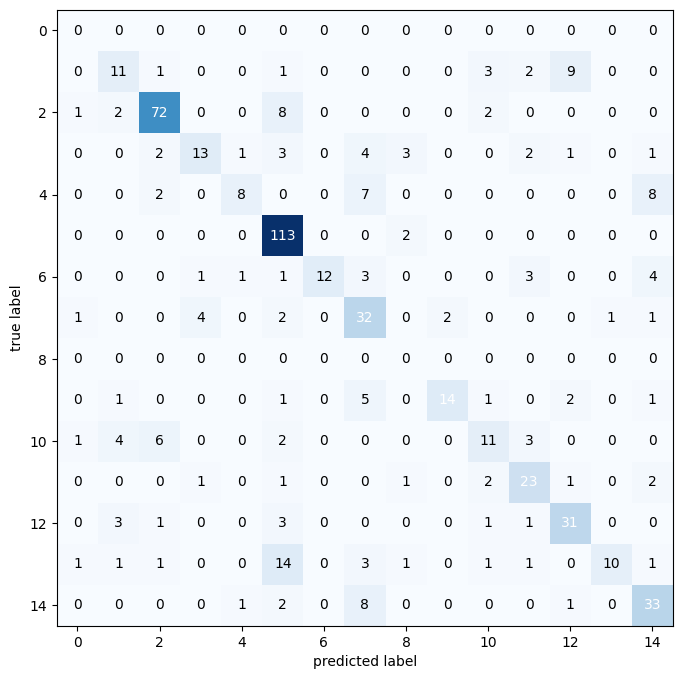

In [ ]:
evaluation(cnn_deep, X_dev, y_dev)

Prediction labels on sample ...
26/26 [==============================] - 2s 87ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.12      0.13      0.13        15
           1       0.00      0.00      0.00         0
           2       0.50      0.70      0.58        27
           3       0.83      0.83      0.83       128
           4       0.53      0.36      0.43        45
           5       0.42      0.20      0.27        25
           6       0.71      0.90      0.79       173
           7       0.87      0.52      0.65        25
           8       0.49      0.73      0.59        64
           9       0.11      0.06      0.08        16
          10       0.00      0.00      0.00         0
          11       0.62      0.64      0.63        25
          12       0.35      0.22      0.27        27
          13       0.80      0.74      0.77        47
          14       0.76      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

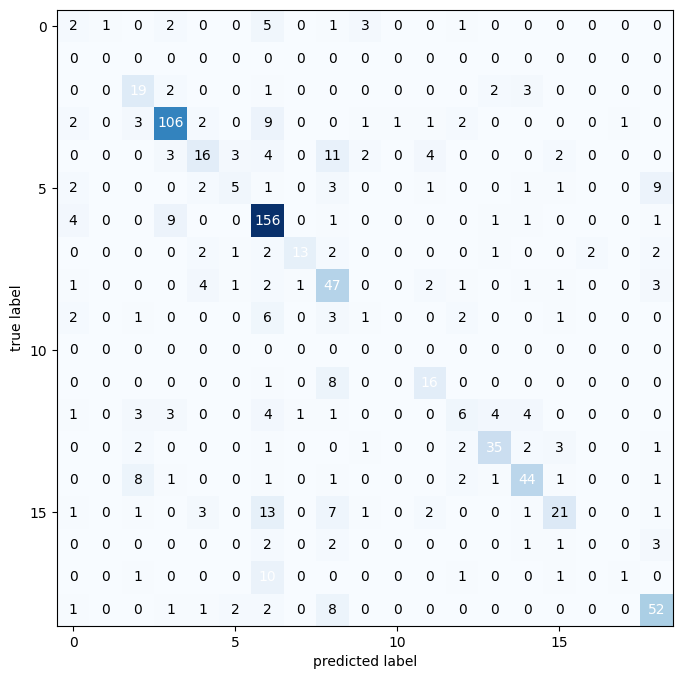

In [ ]:
evaluation(cnn_deep, X_test, y_test)

cnn 2 con preprocessing con apostrofi

In [ ]:
cnn_deep_apo = CNN_deep(vocab_size_apo, 200, 256, maxlen_apo)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 39)]         0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 39, 200)      7382600     ['input_7[0][0]']                
                                                                                                  
 conv1d_29 (Conv1D)             (None, 39, 256)      153856      ['embedding_13[0][0]']           
                                                                                                  
 conv1d_30 (Conv1D)             (None, 39, 256)      205056      ['embedding_13[0][0]']           
                                                                                            

In [ ]:
history_cnn_deep_apo = cnn_deep_apo.fit(np.array(X_train_apo), np.array(y_train_cat), epochs=10,
                    validation_data=(np.array(X_dev_apo), np.array(y_dev_cat)),
                    batch_size=32,
                    callbacks=[stop_callbacks_list])

Epoch 1/10
427/427 [==============================] - 163s 290ms/step - loss: 1.5905 - accuracy: 0.5671 - val_loss: 1.7118 - val_accuracy: 0.4601
Epoch 2/10
427/427 [==============================] - 121s 282ms/step - loss: 0.9889 - accuracy: 0.7194 - val_loss: 1.3851 - val_accuracy: 0.5779
Epoch 3/10
427/427 [==============================] - 119s 278ms/step - loss: 0.5923 - accuracy: 0.8208 - val_loss: 1.2994 - val_accuracy: 0.6341
Epoch 4/10
427/427 [==============================] - 119s 278ms/step - loss: 0.3467 - accuracy: 0.8931 - val_loss: 1.4759 - val_accuracy: 0.6703
Epoch 5/10
427/427 [==============================] - 119s 279ms/step - loss: 0.1943 - accuracy: 0.9410 - val_loss: 1.7666 - val_accuracy: 0.6721
Epoch 6/10
427/427 [==============================] - 119s 279ms/step - loss: 0.1227 - accuracy: 0.9634 - val_loss: 1.8737 - val_accuracy: 0.6449


Prediction labels on sample ...
18/18 [==============================] - 1s 34ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.41      0.33      0.37        27
           3       0.81      0.82      0.82        85
           4       0.39      0.37      0.38        30
           5       0.47      0.36      0.41        25
           6       0.80      0.87      0.83       115
           7       1.00      0.48      0.65        25
           8       0.68      0.58      0.63        43
           9       0.00      0.00      0.00         0
          11       0.66      0.76      0.70        25
          12       0.56      0.37      0.44        27
          13       0.71      0.71      0.71        31
          14       0.66      0.62      0.64        40
          15       0.47      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

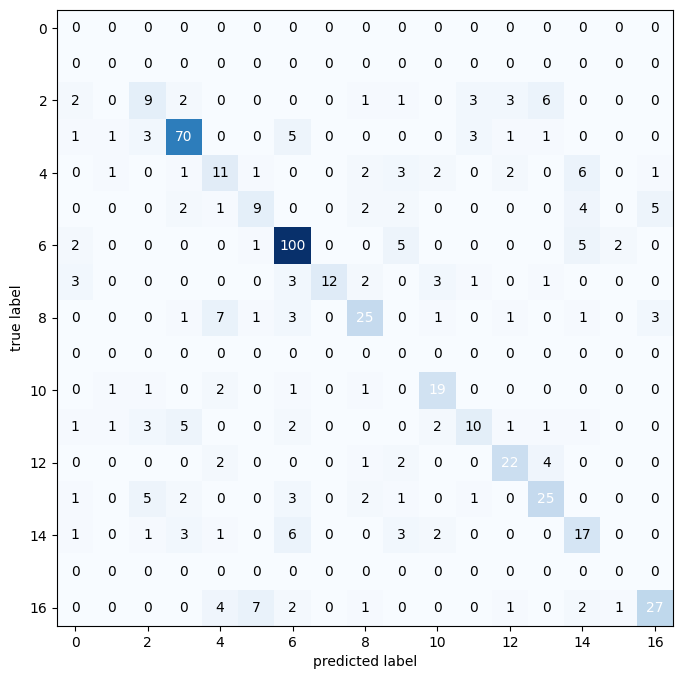

In [ ]:
evaluation(cnn_deep_apo, X_dev_apo, y_dev)

In [ ]:
evaluation(cnn_deep_apo, X_test_apo, y_test)

Prediction labels on sample ...
26/26 [==============================] - 2s 57ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.11      0.20      0.14        15
           1       0.00      0.00      0.00         0
           2       0.58      0.56      0.57        27
           3       0.83      0.83      0.83       128
           4       0.40      0.44      0.42        45
           5       0.34      0.40      0.37        25
           6       0.74      0.86      0.80       173
           7       0.95      0.72      0.82        25
           8       0.64      0.58      0.61        64
           9       0.14      0.19      0.16        16
          11       0.65      0.68      0.67        25
          12       0.27      0.22      0.24        27
          13       0.80      0.74      0.77        47
          14       0.78      0.67      0.72        60
          15       0.57      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

### CNN DEEP 2 : 3 FILTERS 512 X 2, 512 X 3, 512 X 4

In [ ]:
def CNN_deep_2(max_features, embedding_dims, maxlen, class_num=20, last_activation="softmax"):

  sequence_input = Input(shape=(maxlen,))

  embedding_layer = Embedding(max_features, embedding_dims, input_length=maxlen) #(batch_size, maxlen, output_dim) -> (?, ... , ...))

  embedded_sequences = embedding_layer(sequence_input)

  convs = []
  filter_sizes = [2,3,4]

  for fsz in filter_sizes:
    x = Conv1D(512, fsz, activation='relu',padding='same')(embedded_sequences)
    x = MaxPooling1D()(x)
    convs.append(x)

  x = Concatenate(axis=-1)(convs)
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.3)(x)
  output = Dense(class_num, activation = last_activation)(x)

  model = Model(sequence_input, output)

  model.compile(optimizer = "adam", loss ="categorical_crossentropy", metrics = ["accuracy"])
  model.summary()

  return model

In [ ]:
cnn_deep_2 = CNN_deep_2(vocab_size, 200, maxlen)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 embedding_24 (Embedding)       (None, 38, 200)      6603800     ['input_9[0][0]']                
                                                                                                  
 conv1d_40 (Conv1D)             (None, 38, 512)      205312      ['embedding_24[0][0]']           
                                                                                                  
 conv1d_41 (Conv1D)             (None, 38, 512)      307712      ['embedding_24[0][0]']           
                                                                                            

In [ ]:
tf.keras.utils.plot_model(cnn_deep_2,to_file='cnn_deep.png',show_shapes=True)

In [ ]:
history_cnn_deep_2 = cnn_deep_2.fit(np.array(X_train), np.array(y_train_cat), epochs=10,
                    validation_data=(np.array(X_dev), np.array(y_dev_cat)),
                    batch_size=32,
                    callbacks=[stop_callbacks_list])

Epoch 1/10
427/427 [==============================] - 174s 404ms/step - loss: 1.6355 - accuracy: 0.5620 - val_loss: 1.7683 - val_accuracy: 0.4348
Epoch 2/10
427/427 [==============================] - 165s 386ms/step - loss: 1.0980 - accuracy: 0.6870 - val_loss: 1.5137 - val_accuracy: 0.4946
Epoch 3/10
427/427 [==============================] - 164s 384ms/step - loss: 0.7869 - accuracy: 0.7588 - val_loss: 1.4197 - val_accuracy: 0.6304
Epoch 4/10
427/427 [==============================] - 160s 374ms/step - loss: 0.5656 - accuracy: 0.8255 - val_loss: 1.2487 - val_accuracy: 0.6739
Epoch 5/10
427/427 [==============================] - 160s 375ms/step - loss: 0.4215 - accuracy: 0.8668 - val_loss: 1.3016 - val_accuracy: 0.6793
Epoch 6/10
427/427 [==============================] - 164s 385ms/step - loss: 0.3302 - accuracy: 0.8942 - val_loss: 1.5419 - val_accuracy: 0.6540
Epoch 7/10
427/427 [==============================] - 174s 408ms/step - loss: 0.2587 - accuracy: 0.9194 - val_loss: 1.8200 -

Prediction labels on sample ...
18/18 [==============================] - 2s 81ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.42      0.48      0.45        27
           3       0.79      0.87      0.83        85
           4       0.37      0.47      0.41        30
           5       0.43      0.12      0.19        25
           6       0.76      0.91      0.83       115
           7       0.62      0.40      0.49        25
           8       0.79      0.53      0.64        43
           9       0.00      0.00      0.00         0
          11       0.86      0.72      0.78        25
          12       0.50      0.33      0.40        27
          13       0.96      0.77      0.86        31
          14       0.74      0.57      0.65        40
          15       0.68      0.56      0.61        34
          19       0.56      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

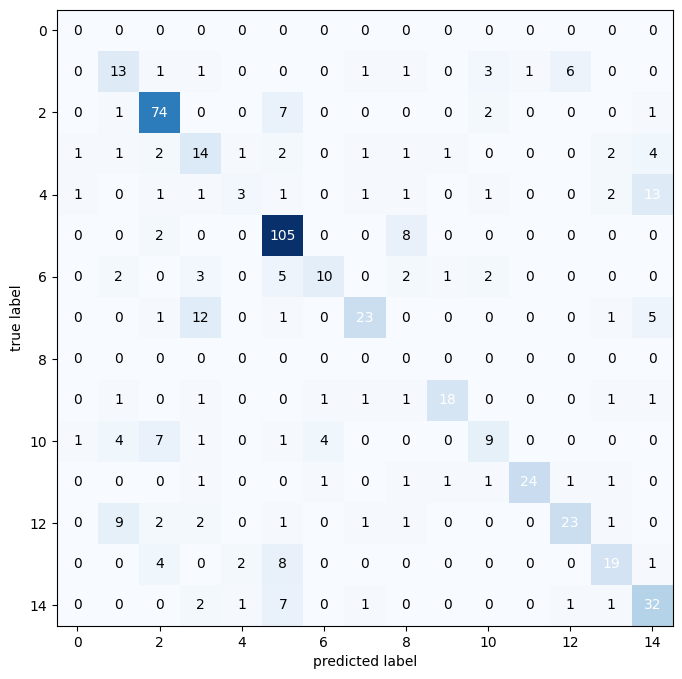

In [ ]:
evaluation(cnn_deep_2, X_dev, y_dev)

Prediction labels on sample ...
26/26 [==============================] - 2s 73ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.15      0.13      0.14        15
           2       0.40      0.67      0.50        27
           3       0.77      0.85      0.81       128
           4       0.46      0.58      0.51        45
           5       0.44      0.32      0.37        25
           6       0.71      0.92      0.81       173
           7       0.58      0.44      0.50        25
           8       0.70      0.61      0.65        64
           9       0.00      0.00      0.00        16
          11       0.83      0.60      0.70        25
          12       0.15      0.07      0.10        27
          13       0.89      0.70      0.79        47
          14       0.81      0.57      0.67        60
          15       0.58      0.55      0.57        51
          16       0.50      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


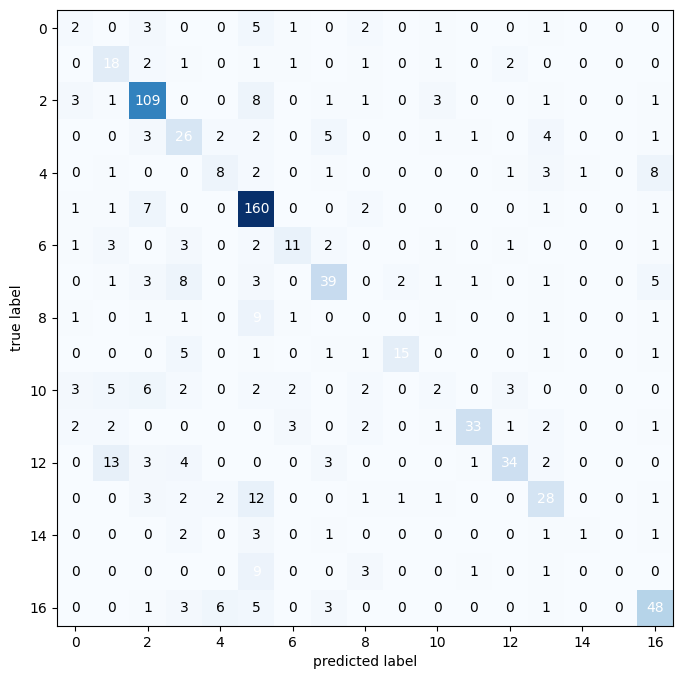

In [ ]:
evaluation(cnn_deep_2, X_test, y_test)

upgrade della cnn con concatenation

In [ ]:
def CNN_deep_3(max_features, embedding_dims, maxlen, class_num=20, last_activation="softmax"):

  sequence_input = Input(shape=(maxlen,))

  embedding_layer = Embedding(max_features, embedding_dims, input_length=maxlen) #(batch_size, maxlen, output_dim) -> (?, ... , ...))

  embedded_sequences = embedding_layer(sequence_input)

  convs = []
  filter_sizes = [3,4,5]

  for fsz in filter_sizes:
    x = Conv1D(512, fsz, activation='relu',padding='same')(embedded_sequences)
    x = GlobalMaxPool1D()(x)
    convs.append(x)

  x = Concatenate(axis=-1)(convs)
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.4)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.4)(x)
  output = Dense(class_num, activation = last_activation)(x)

  model = Model(sequence_input, output)

  model.compile(optimizer = "adam", loss ="categorical_crossentropy", metrics = ["accuracy"])
  model.summary()

  return model


In [ ]:
cnn_deep_3 = CNN_deep_3(vocab_size_apo, 200, maxlen_apo)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 39)]         0           []                               
                                                                                                  
 embedding_24 (Embedding)       (None, 39, 200)      7382600     ['input_5[0][0]']                
                                                                                                  
 conv1d_39 (Conv1D)             (None, 39, 512)      307712      ['embedding_24[0][0]']           
                                                                                                  
 conv1d_40 (Conv1D)             (None, 39, 512)      410112      ['embedding_24[0][0]']           
                                                                                            

In [ ]:
history_cnn_deep_3 = cnn_deep_3.fit(np.array(X_train_apo), np.array(y_train_cat), epochs=10,
                    validation_data=(np.array(X_dev_apo), np.array(y_dev_cat)),
                    batch_size=32,
                    callbacks=[stop_callbacks_list]
                                  )

Epoch 1/10
427/427 [==============================] - 117s 271ms/step - loss: 1.7044 - accuracy: 0.5509 - val_loss: 1.7894 - val_accuracy: 0.4384
Epoch 2/10
427/427 [==============================] - 113s 265ms/step - loss: 1.1646 - accuracy: 0.6745 - val_loss: 1.6368 - val_accuracy: 0.5254
Epoch 3/10
427/427 [==============================] - 110s 257ms/step - loss: 0.8593 - accuracy: 0.7502 - val_loss: 1.3788 - val_accuracy: 0.6069
Epoch 4/10
427/427 [==============================] - 110s 257ms/step - loss: 0.6718 - accuracy: 0.7936 - val_loss: 1.4227 - val_accuracy: 0.6540
Epoch 5/10
427/427 [==============================] - 109s 256ms/step - loss: 0.5371 - accuracy: 0.8340 - val_loss: 1.4109 - val_accuracy: 0.6866
Epoch 6/10
427/427 [==============================] - 112s 262ms/step - loss: 0.4403 - accuracy: 0.8590 - val_loss: 1.4063 - val_accuracy: 0.7065


Prediction labels on sample ...
18/18 [==============================] - 2s 113ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           2       0.58      0.52      0.55        27
           3       0.85      0.88      0.87        85
           4       0.41      0.53      0.46        30
           5       0.43      0.12      0.19        25
           6       0.76      0.94      0.84       115
           7       0.91      0.40      0.56        25
           8       0.79      0.70      0.74        43
          11       0.53      0.76      0.62        25
          12       1.00      0.33      0.50        27
          13       0.88      0.74      0.81        31
          14       0.66      0.72      0.69        40
          15       0.54      0.62      0.58        34
          19       0.69      0.73      0.71        45

    accuracy                           0.71       552
   macro avg       0.69      

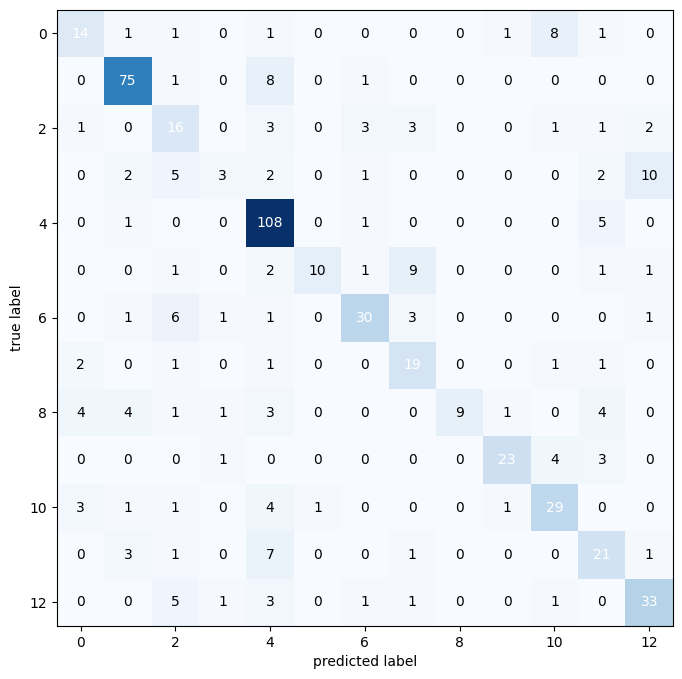

In [ ]:
evaluation(cnn_deep_3, X_dev_apo, y_dev)

Prediction labels on sample ...
26/26 [==============================] - 1s 57ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           2       0.49      0.74      0.59        27
           3       0.83      0.88      0.85       128
           4       0.31      0.36      0.33        45
           5       0.33      0.08      0.13        25
           6       0.76      0.91      0.83       173
           7       0.89      0.32      0.47        25
           8       0.61      0.67      0.64        64
           9       0.00      0.00      0.00        16
          11       0.44      0.56      0.49        25
          12       0.42      0.19      0.26        27
          13       0.97      0.66      0.78        47
          14       0.73      0.77      0.75        60
          15       0.42      0.69      0.52        51
          16       0.00      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


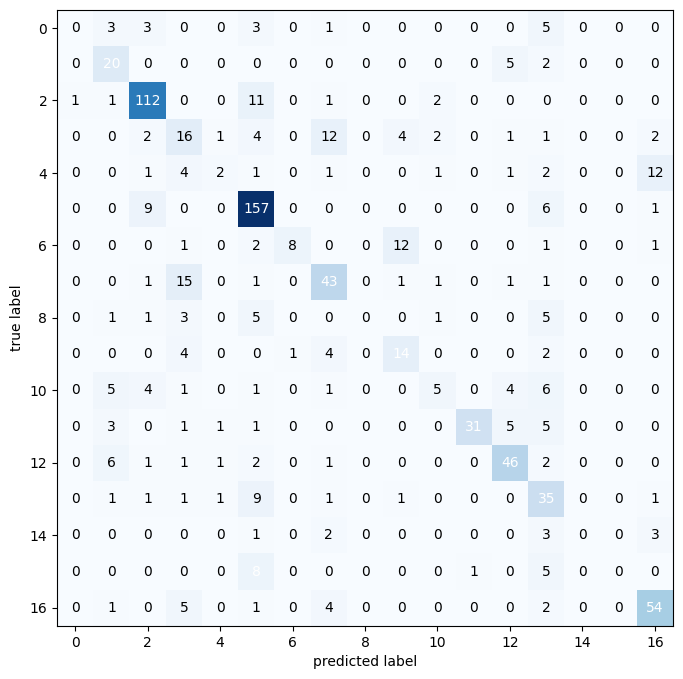

In [ ]:
evaluation(cnn_deep_3, X_test_apo, y_test)

prova con testo con preprocessing normale

In [ ]:
cnn_deep_3_1 = CNN_deep_3(vocab_size, 200, maxlen)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 38, 200)      6603800     ['input_5[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 38, 512)      307712      ['embedding_4[0][0]']            
                                                                                                  
 conv1d_13 (Conv1D)             (None, 38, 512)      410112      ['embedding_4[0][0]']            
                                                                                            

In [ ]:
history_cnn_deep_3_1 = cnn_deep_3_1.fit(np.array(X_train), np.array(y_train_cat), epochs=10,
                    validation_data=(np.array(X_dev), np.array(y_dev_cat)),
                    batch_size=32,
                    callbacks=[stop_callbacks_list])

Epoch 1/10
427/427 [==============================] - 172s 399ms/step - loss: 1.6783 - accuracy: 0.5558 - val_loss: 1.7802 - val_accuracy: 0.4293
Epoch 2/10
427/427 [==============================] - 176s 412ms/step - loss: 1.1711 - accuracy: 0.6730 - val_loss: 1.5843 - val_accuracy: 0.4891
Epoch 3/10
427/427 [==============================] - 169s 396ms/step - loss: 0.8963 - accuracy: 0.7282 - val_loss: 1.3527 - val_accuracy: 0.6014
Epoch 4/10
427/427 [==============================] - 161s 377ms/step - loss: 0.6979 - accuracy: 0.7884 - val_loss: 1.3026 - val_accuracy: 0.6449
Epoch 5/10
427/427 [==============================] - 161s 378ms/step - loss: 0.5548 - accuracy: 0.8299 - val_loss: 1.3831 - val_accuracy: 0.6685
Epoch 6/10
427/427 [==============================] - 169s 395ms/step - loss: 0.4715 - accuracy: 0.8535 - val_loss: 1.3463 - val_accuracy: 0.7011
Epoch 7/10
427/427 [==============================] - 176s 412ms/step - loss: 0.4001 - accuracy: 0.8723 - val_loss: 1.5429 -

Prediction labels on sample ...
18/18 [==============================] - 2s 78ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.57      0.44      0.50        27
           3       0.84      0.89      0.87        85
           4       0.44      0.50      0.47        30
           5       0.30      0.24      0.27        25
           6       0.79      0.95      0.86       115
           7       1.00      0.44      0.61        25
           8       0.68      0.70      0.69        43
           9       0.00      0.00      0.00         0
          11       0.54      0.56      0.55        25
          12       0.67      0.52      0.58        27
          13       0.84      0.84      0.84        31
          14       0.68      0.70      0.69        40
          15       0.69      0.65      0.67        34
          19       0.78      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

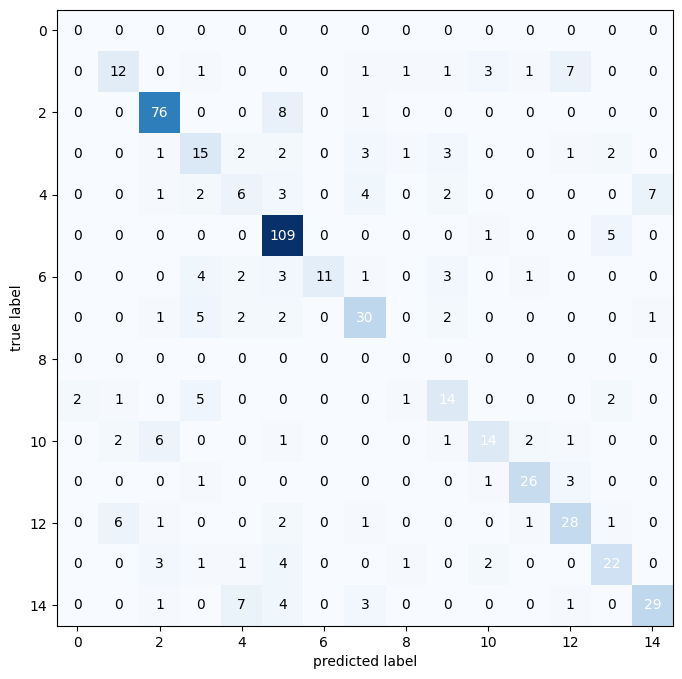

In [ ]:
evaluation(cnn_deep_3_1, X_dev, y_dev)

Prediction labels on sample ...
26/26 [==============================] - 2s 78ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.40      0.13      0.20        15
           2       0.63      0.70      0.67        27
           3       0.85      0.84      0.84       128
           4       0.42      0.33      0.37        45
           5       0.23      0.24      0.24        25
           6       0.71      0.94      0.81       173
           7       0.78      0.28      0.41        25
           8       0.63      0.69      0.66        64
           9       0.00      0.00      0.00        16
          11       0.31      0.32      0.31        25
          12       0.30      0.44      0.36        27
          13       0.92      0.70      0.80        47
          14       0.76      0.75      0.76        60
          15       0.74      0.63      0.68        51
          16       0.00      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


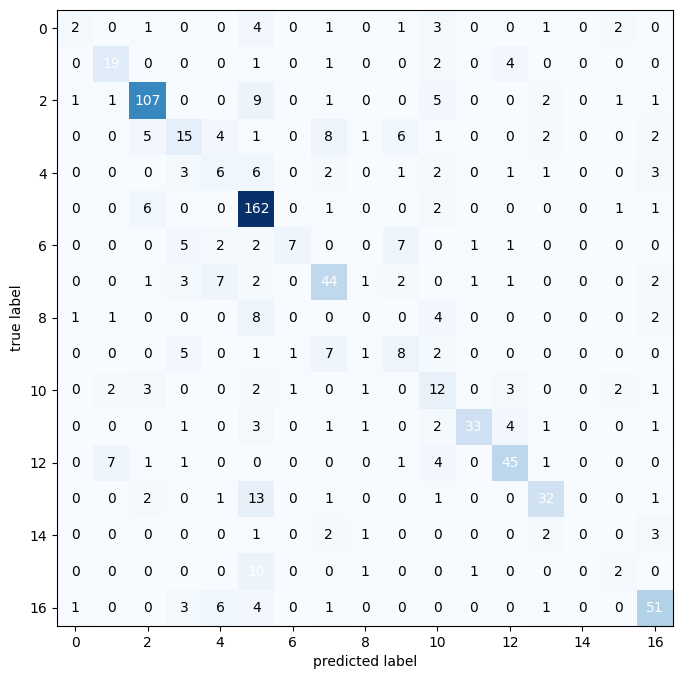

In [ ]:
evaluation(cnn_deep_3_1, X_test, y_test)

**LSTM + TFIDF**

In [ ]:
from spacy.lang.it.stop_words import STOP_WORDS as it_stop

In [ ]:
#TF-IDF : le parole sono conteggiate per frequenza e poi calcolato un peso relativo (importanza della frequenza delle parole meno frequenti)
tfidf_ngrams = TfidfVectorizer(ngram_range=(1,3), max_features= 500, stop_words = list(it_stop))

X_train_tfidf = tfidf_ngrams.fit_transform(df_train['text']).toarray()
X_dev_tfidf = tfidf_ngrams.transform(df_dev['text']).toarray()
print('Train size: ',X_train_tfidf.shape)
print('dev size: ',X_dev_tfidf.shape)

print("X_train shape:", X_train.shape)
print("X_dev shape:", X_dev.shape)
print('Train tfidf ngrams size: ',X_train_tfidf.shape)
print('dev tfidf ngramssize: ',X_dev_tfidf.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gl', 'nient'] not in stop_words.
  warnings.warn(


Train size:  (13653, 500)
dev size:  (552, 500)
X_train shape: (13653, 38)
X_dev shape: (552, 38)
Train tfidf ngrams size:  (13653, 500)
dev tfidf ngramssize:  (552, 500)


In [ ]:
#TF-IDF : le parole sono conteggiate per frequenza e poi calcolato un peso relativo (importanza della frequenza delle parole meno frequenti)
tfidf_ngrams_apo = TfidfVectorizer(ngram_range=(1,3), max_features= 500, stop_words = list(it_stop))

X_train_tfidf_apo = tfidf_ngrams_apo.fit_transform(df_train_apo['text']).toarray()
X_dev_tfidf_apo = tfidf_ngrams_apo.transform(df_dev_apo['text']).toarray()
print('Train size: ',X_train_tfidf_apo.shape)
print('dev size: ',X_dev_tfidf_apo.shape)

Train size:  (13653, 500)
dev size:  (552, 500)


In [ ]:
print("X_train shape:", X_train_apo.shape)
print("X_dev shape:", X_dev_apo.shape)
print('Train tfidf ngrams size: ',X_train_tfidf_apo.shape)
print('dev tfidf ngramssize: ',X_dev_tfidf_apo.shape)

X_train shape: (13653, 39)
X_dev shape: (552, 39)
Train tfidf ngrams size:  (13653, 500)
dev tfidf ngramssize:  (552, 500)


In [ ]:
#prepare also test set
X_test_tfidf = tfidf_ngrams.transform(df_test_apo['text']).toarray()

X_test_tfidf_apo = tfidf_ngrams_apo.transform(df_test_apo['text']).toarray()

In [ ]:
def LSTM_TFIDF(max_features, embedding_dims, maxlen, tfidf_dim, class_num=20, last_activation="softmax"):

  input_lstm = Input(shape=(maxlen,))
  input = Input(shape=(tfidf_dim,))

  embedding_layer = Embedding(max_features, output_dim = embedding_dims, input_length = maxlen)
  embedded_sequences = embedding_layer(input_lstm)

  lstm = Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2,
                            kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(embedded_sequences)
  lstm = Flatten()(lstm)
  lstm = Dense(128, activation = "relu")(lstm)
  lstm = Dropout(0.3)(lstm)
  lstm = Dense(64, activation = "relu")(lstm)
  lstm = Dropout(0.3)(lstm)

  ngrams_dense = Dense(128, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(input)
  ngrams_dense = Dropout(0.3)(ngrams_dense)
  ngrams_dense = Dense(64, activation="relu")(ngrams_dense)
  ngrams_dense = Dropout(0.3)(ngrams_dense)

  concat_layer = Concatenate()([lstm, ngrams_dense])
  concat_layer = Flatten()(concat_layer)

  dense = Dense(64, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(concat_layer)
  dense = Dropout(0.2)(dense)
  output = Dense(20, activation = "softmax")(dense)

  model =  Model([input_lstm, input], output)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()

  # Plot model graph
  #tf.keras.utils.plot_model(model, show_shapes=True)

  return model

In [ ]:
model_lstm_tfidf = LSTM_TFIDF(vocab_size, 200, maxlen, 500)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 38, 200)      6602800     ['input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 38, 256)     336896      ['embedding_4[0][0]']            
 )                                                                                                
                                                                                                  
 flatten_4 (Flatten)            (None, 9728)         0           ['bidirectional_1[0][0]']    

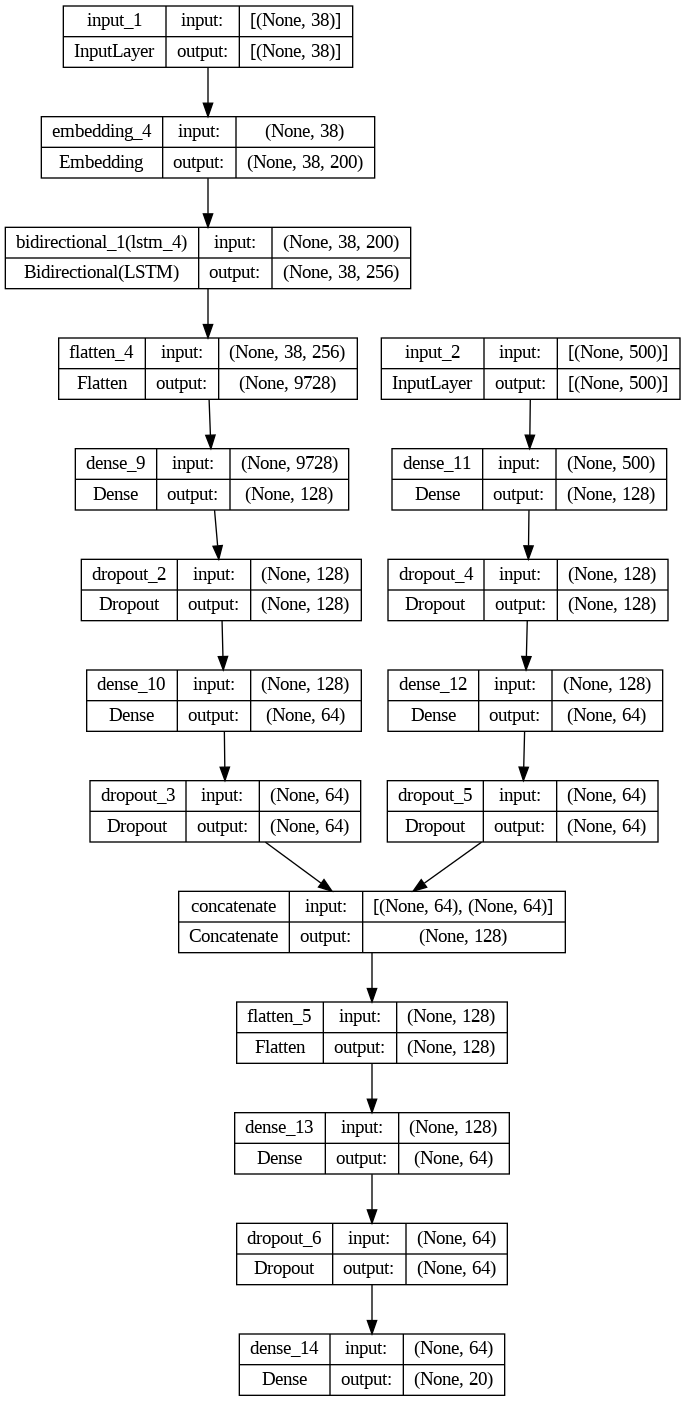

In [ ]:
# Plot model graph
tf.keras.utils.plot_model(model_lstm_tfidf, show_shapes=True)

In [ ]:
history_lstm_tfidf = model_lstm_tfidf.fit(x=[X_train, X_train_tfidf],
                        y=y_train_cat,
                        batch_size = 32,
                        epochs = 10,
                        verbose = 1,
                        validation_data = ([X_dev, X_dev_tfidf], y_dev_cat),
                        callbacks = [stop_callbacks_list],
                        #class_weight = dict_weights
                        )

Epoch 1/10
427/427 [==============================] - 187s 422ms/step - loss: 1.6439 - accuracy: 0.5483 - val_loss: 1.6220 - val_accuracy: 0.4783
Epoch 2/10
427/427 [==============================] - 176s 413ms/step - loss: 1.0926 - accuracy: 0.6903 - val_loss: 1.4132 - val_accuracy: 0.5362
Epoch 3/10
427/427 [==============================] - 180s 422ms/step - loss: 0.8189 - accuracy: 0.7546 - val_loss: 1.4240 - val_accuracy: 0.5725
Epoch 4/10
427/427 [==============================] - 187s 437ms/step - loss: 0.6226 - accuracy: 0.8088 - val_loss: 1.3558 - val_accuracy: 0.6377
Epoch 5/10
427/427 [==============================] - 183s 428ms/step - loss: 0.4637 - accuracy: 0.8547 - val_loss: 1.3432 - val_accuracy: 0.6359
Epoch 6/10
427/427 [==============================] - 181s 423ms/step - loss: 0.3614 - accuracy: 0.8852 - val_loss: 1.4893 - val_accuracy: 0.6721
Epoch 7/10
427/427 [==============================] - 193s 452ms/step - loss: 0.2965 - accuracy: 0.9087 - val_loss: 1.4600 -

Prediction labels on sample ...
26/26 [==============================] - 3s 73ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.25      0.27      0.26        15
           1       0.00      0.00      0.00         0
           2       0.39      0.44      0.41        27
           3       0.80      0.85      0.83       128
           4       0.45      0.40      0.42        45
           5       0.30      0.28      0.29        25
           6       0.72      0.91      0.80       173
           7       0.67      0.64      0.65        25
           8       0.67      0.67      0.67        64
           9       0.00      0.00      0.00        16
          11       0.59      0.68      0.63        25
          12       0.32      0.22      0.26        27
          13       0.94      0.70      0.80        47
          14       0.75      0.80      0.77        60
          15       0.74      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

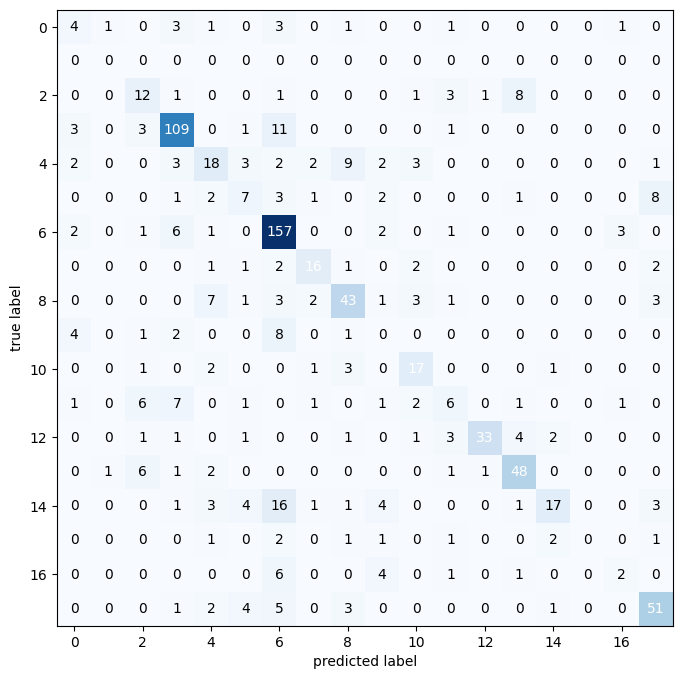

In [ ]:
evaluation(model_lstm_tfidf, [X_test, X_test_tfidf], y_test)

In [ ]:
evaluation(model_3_cnn, [X_dev, X_dev_tfidf], y_dev)

Prediction labels on sample ...
18/18 [==============================] - 1s 40ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.77      0.37      0.50        27
           3       0.77      0.91      0.83        85
           4       0.67      0.53      0.59        30
           5       0.38      0.24      0.29        25
           6       0.78      0.95      0.86       115
           7       0.93      0.52      0.67        25
           8       0.58      0.65      0.62        43
           9       0.00      0.00      0.00         0
          11       0.71      0.60      0.65        25
          12       0.77      0.37      0.50        27
          13       0.86      0.81      0.83        31
          14       0.66      0.68      0.67        40
          15       0.84      0.62      0.71        34
          16       0.00      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

Prediction labels on sample ...
26/26 [==============================] - 1s 35ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.08      0.07      0.07        15
           1       0.00      0.00      0.00         0
           2       0.64      0.52      0.57        27
           3       0.76      0.93      0.84       128
           4       0.66      0.42      0.51        45
           5       0.50      0.28      0.36        25
           6       0.71      0.93      0.81       173
           7       0.91      0.40      0.56        25
           8       0.65      0.69      0.67        64
           9       1.00      0.06      0.12        16
          11       0.70      0.76      0.73        25
          12       0.38      0.19      0.25        27
          13       0.94      0.72      0.82        47
          14       0.69      0.83      0.76        60
          15       0.71      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

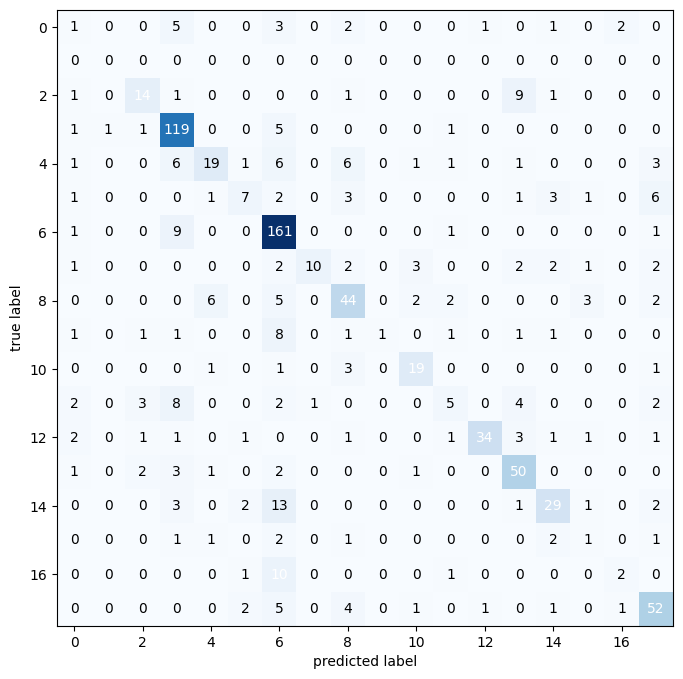

In [ ]:
evaluation(model_3_cnn, [X_test, X_test_tfidf], y_test)

In [ ]:
model_lstm_tfidf_apo = LSTM_TFIDF(vocab_size_apo, 200, maxlen_apo, 500)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 39)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 39, 200)      7381600     ['input_3[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 39, 256)     336896      ['embedding_5[0][0]']            
 )                                                                                                
                                                                                                  
 flatten_6 (Flatten)            (None, 9984)         0           ['bidirectional_2[0][0]']  

In [ ]:
# con apostrofi
history_lstm_tfidf_apo = model_lstm_tfidf_apo.fit(x=[X_train_apo, X_train_tfidf_apo],
                        y=y_train_cat,
                        batch_size = 32,
                        epochs = 10,
                        verbose = 1,
                        validation_data = ([X_dev_apo, X_dev_tfidf_apo], y_dev_cat),
                        callbacks = [stop_callbacks_list],
                        #class_weight = dict_weights
                        )

Epoch 1/10
427/427 [==============================] - 213s 441ms/step - loss: 1.6894 - accuracy: 0.5517 - val_loss: 1.7364 - val_accuracy: 0.4547
Epoch 2/10
427/427 [==============================] - 186s 435ms/step - loss: 1.1449 - accuracy: 0.6816 - val_loss: 1.4679 - val_accuracy: 0.5091
Epoch 3/10
427/427 [==============================] - 184s 430ms/step - loss: 0.8375 - accuracy: 0.7480 - val_loss: 1.3427 - val_accuracy: 0.5960
Epoch 4/10
427/427 [==============================] - 182s 426ms/step - loss: 0.6400 - accuracy: 0.8043 - val_loss: 1.3003 - val_accuracy: 0.5978
Epoch 5/10
427/427 [==============================] - 186s 435ms/step - loss: 0.4850 - accuracy: 0.8492 - val_loss: 1.2989 - val_accuracy: 0.6413
Epoch 6/10
427/427 [==============================] - 186s 435ms/step - loss: 0.3787 - accuracy: 0.8823 - val_loss: 1.4858 - val_accuracy: 0.6775
Epoch 7/10
427/427 [==============================] - 190s 444ms/step - loss: 0.2899 - accuracy: 0.9075 - val_loss: 1.6297 -

In [ ]:
evaluation(model_lstm_tfidf_apo, [X_dev_apo, X_dev_tfidf_apo], y_dev)

Prediction labels on sample ...
18/18 [==============================] - 3s 163ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.50      0.52      0.51        27
           3       0.86      0.82      0.84        85
           4       0.41      0.40      0.41        30
           5       0.46      0.44      0.45        25
           6       0.70      0.90      0.78       115
           7       0.81      0.52      0.63        25
           8       0.76      0.58      0.66        43
           9       0.00      0.00      0.00         0
          11       0.81      0.68      0.74        25
          12       0.45      0.33      0.38        27
          13       0.92      0.77      0.84        31
          14       0.71      0.75      0.73        40
          15       0.84      0.47      0.60        34
          17       0.00      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

In [ ]:
evaluation(model_lstm_tfidf_apo, [X_test_apo, X_test_tfidf_apo], y_test)

Prediction labels on sample ...
26/26 [==============================] - 1s 56ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           2       0.39      0.59      0.47        27
           3       0.85      0.81      0.83       128
           4       0.48      0.47      0.47        45
           5       0.33      0.28      0.30        25
           6       0.72      0.95      0.82       173
           7       0.78      0.72      0.75        25
           8       0.56      0.61      0.58        64
           9       0.07      0.12      0.09        16
          11       0.86      0.76      0.81        25
          12       0.25      0.19      0.21        27
          13       0.92      0.72      0.81        47
          14       0.73      0.68      0.71        60
          15       0.85      0.57      0.68        51
          16       0.00      0.

### CROSS VALIDATION CON MODELLO + PERFORMANTE : "***CNN CON 1 CONV 512 x 3 + DENSE LAYERS + OUTPUT)***"

In [ ]:
X = np.concatenate((X_train_apo, X_dev_apo), axis=0)
Y = np.concatenate((y_train, y_dev), axis=0)
Y_cat = to_categorical(Y, dtype='uint8')

cnn_1_cross = CNN_1(vocab_size_apo, 200, 512, maxlen_apo)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 39, 200)           7382600   
                                                                 
 conv1d_15 (Conv1D)          (None, 37, 512)           307712    
                                                                 
 global_max_pooling1d_15 (Gl  (None, 512)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_30 (Dense)            (None, 128)               65664     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 20)                2580      
                                                     

In [ ]:
#eval on test set
X_test_apo = tokenizer_apo.texts_to_sequences(test_clean_apo['text'])
#print("X_dev_apo[0]",X_dev_apo[0])

X_test_apo = pad_sequences(X_test_apo, padding ="post" , maxlen = maxlen_apo)
print("After Padding ...")
print("X_test shape con apostrofi:", X_test_apo.shape)

After Padding ...
X_test shape con apostrofi: (818, 39)


In [ ]:
history_cross = cnn_1_cross.fit(np.array(X), np.array(Y_cat), epochs=10,
                                          validation_data=(np.array(X_test_apo), np.array(y_test_cat)),
                                          batch_size=32,
                                          callbacks=[stop_callbacks_list]
                                          )

Epoch 1/10
444/444 [==============================] - 50s 112ms/step - loss: 1.5612 - accuracy: 0.5844 - val_loss: 1.5528 - val_accuracy: 0.5452
Epoch 2/10
444/444 [==============================] - 51s 116ms/step - loss: 0.8672 - accuracy: 0.7654 - val_loss: 1.0972 - val_accuracy: 0.6980
Epoch 3/10
444/444 [==============================] - 50s 113ms/step - loss: 0.4234 - accuracy: 0.8814 - val_loss: 1.1186 - val_accuracy: 0.7078
Epoch 4/10
444/444 [==============================] - 51s 114ms/step - loss: 0.1992 - accuracy: 0.9447 - val_loss: 1.3665 - val_accuracy: 0.7127
Epoch 5/10
444/444 [==============================] - 51s 114ms/step - loss: 0.0954 - accuracy: 0.9742 - val_loss: 1.5959 - val_accuracy: 0.7200


Prediction labels on sample ...
26/26 [==============================] - 0s 12ms/step
Evaluation in course ... 
Classification Report & Confusion Matrix ... 
              precision    recall  f1-score   support

           0       0.43      0.20      0.27        15
           2       0.61      0.74      0.67        27
           3       0.83      0.92      0.87       128
           4       0.55      0.49      0.52        45
           5       0.50      0.36      0.42        25
           6       0.74      0.92      0.82       173
           7       0.85      0.68      0.76        25
           8       0.55      0.66      0.60        64
           9       0.22      0.12      0.16        16
          10       0.00      0.00      0.00         0
          11       0.76      0.76      0.76        25
          12       0.62      0.19      0.29        27
          13       1.00      0.77      0.87        47
          14       0.79      0.82      0.80        60
          15       0.72      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: Ru

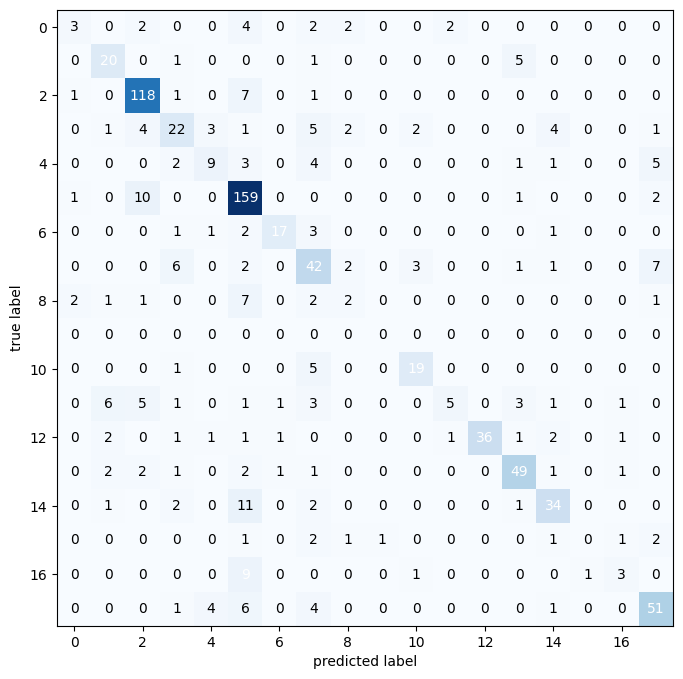

In [ ]:
evaluation(cnn_1_cross, X_test_apo, y_test)

## UPGRADE: PROVA DEI MIGLIORI MODELLI CON AGGIUNTA REGOLAZIONE L2

In [ ]:
def CNN_deep_reg(max_features, embedding_dims, maxlen, class_num=20, last_activation="softmax"):

  sequence_input = Input(shape=(maxlen,))

  embedding_layer = Embedding(max_features, embedding_dims, input_length=maxlen) #(batch_size, maxlen, output_dim) -> (?, ... , ...))

  embedded_sequences = embedding_layer(sequence_input)

  convs = []
  filter_sizes = [3,4,5]

  for fsz in filter_sizes:
    x = Conv1D(256, fsz, activation='relu',padding='same',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(embedded_sequences)
    x = MaxPooling1D()(x)
    convs.append(x)

  x = Concatenate(axis=-1)(convs)
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.3)(x)
  output = Dense(class_num, activation = last_activation)(x)

  model = Model(sequence_input, output)

  model.compile(optimizer = "adam", loss ="categorical_crossentropy", metrics = ["accuracy"])
  model.summary()

  return model